In [17]:
# It's dangerous to go alone, take these
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode, wilcoxon, ranksums, spearmanr, pearsonr
from sklearn.metrics import f1_score, confusion_matrix, classification_report 
from os import listdir
%matplotlib inline

clustlist = ['gsea', 'gsva','ora','metaneighbor','adobo','sccatch','cibersort']
celllist =  ['LAmbDA',
             'Cell_BLAST', # this leaves the first and last character of the predictions off, can't use it.
             'RF',
             'kNN9',
             'ACTINN',
             'LDA',
             'LDArej',
             'CaSTLe',
             'scmapcluster',
             'SVM',
             'SingleCellNet',
             'scVI',
             'SVMrej',
             'scmapcell',
             'NMC',
             'singleR',
             'scID',
             'scPred',
             'CHETAH',
            ]

dataset_rename = {'cb':'Chung',
                  'dg': 'Darmanis',
                  'jam': 'Jerby Arnon',
                  'li_crc': 'Li',
                  'llc': 'Lambrechts',
                  'peng': 'Peng',
                  'tm':'Tirosh',
                  'vg':'Van Galen',
                 }
#manual from lambrechts
celltypes = ['ERYTHROBLASTS', 
             'BASAL_CELLS', 
             'LYMPHATIC_EC', 
             'SECRETORY_CLUB_CELLS',
             'EPITHELIAL_CELLS', 
             'GRANULOCYTES', 
             'DENDRITIC_CELLS', 
             'MAST_CELLS', 
             'LANGERHANS_CELLS', 
             'ALVEOLAR_CELL', 
             'FIBROBLASTS', 
             'ENDOTHELIAL_CELL', 
             'NATURAL_KILLER_CELLS', 
             'B_CELLS', 
             'CANCER_CELLS', 
             'MACROPHAGES', 
             'T_CELLS', 
            ]

cellrename = {'NK':'NK', 
              'BCELL':"BCELL", 
              'ENDO':"ENDOTHELIAL", 
              'CAF':"CAF", 
              'MACRO':"MACROPHAGE", 
              'TCELL':"TCELL", 
              'UNLABELED':'UNLABELED',
              'TUMOR':"MELANOMA"}

singletons = ['Cell_BLAST','kNN9','scPred','scmapcell','scmapcluster']

# Read the original dataset and filter it

In [18]:
fulldf = pd.read_csv("/Users/erik/Documents/school/research/labelling_project/\
performance/seurat/tm_classification_report.tsv", sep='\t')
fulldf = fulldf[fulldf['method'].isin(celllist)]
#fulldf = fulldf[fulldf['support']>=500]
fulldf['cellprop']=fulldf['support']/3589
#drop unnecessary rows and sort rows from fewest to most cells
fulldf = fulldf[fulldf['class']!='macro avg']
fulldf = fulldf[fulldf['class']!='weighted avg']
fulldf = fulldf[fulldf['class']!='UNLABELED']
fulldf = fulldf[fulldf['class']!='UNAVAILABLE']
fulldf = fulldf.sort_values('support',axis=0)
fulldf['dataset'] = 'original'
celltypes = list((fulldf[fulldf['method']=='SVM']['class']))
#make a dictionary we can use to sort the other dataframe
sortdict = pd.Series(fulldf['support'].values,index=fulldf['class']).to_dict()
print(fulldf[fulldf['method']=='SVM'][['support','class']])
print(celltypes)
print(set(fulldf['class']))
    
display(fulldf.head())

    support        class
70       51           NK
66       56          CAF
67       62  ENDOTHELIAL
68      120   MACROPHAGE
65      512        BCELL
69     1252     MELANOMA
71     2044        TCELL
['NK', 'CAF', 'ENDOTHELIAL', 'MACROPHAGE', 'BCELL', 'MELANOMA', 'TCELL']
{'NK', 'BCELL', 'MELANOMA', 'CAF', 'ENDOTHELIAL', 'TCELL', 'MACROPHAGE'}


,method,class,precision,recall,f1_score,support,specificity,cellprop,dataset
172,LAmbDA,NK,0.261194,0.686275,0.378378,51,0.975531,0.01421,original
117,NMC,NK,0.878049,0.705882,0.782609,51,0.998764,0.01421,original
135,ACTINN,NK,1.000000,0.274510,0.430769,51,1.000000,0.01421,original
210,scID,NK,0.071053,0.529412,0.125290,51,0.912753,0.01421,original
107,LDArej,NK,0.966667,0.568627,0.716049,51,0.999753,0.01421,original


In [15]:
def compare_subsampled(filename, fulldf = fulldf):
    title = filename.split('.')[0]
    title = title.split('/')[1]
    plotdir = title.split('_')[0]+"_plots"
    #subsampled file and empty dictionary for the performance
    llc_subsample = pd.read_csv(filename, sep='\t')
    print(set(llc_subsample['truth']))
    perfdf = pd.DataFrame(columns = ['method', 
                                     'class', 
                                     'precision', 
                                     'recall', 
                                     'f1_score', 
                                     'support', 
                                     'specificity'])
    
    # for each method that we're testing, compute a score and add it to a new dataframe
    llc_subsample['truth'] = llc_subsample.apply(lambda row: cellrename[row['truth']],axis=1)
    for method in celllist:
        if method == "scPred" and title == "Lambrechts_LC_1600":
            fulldf = fulldf[fulldf['method']!="scPred"]
            continue
        llc_subsample[method] = llc_subsample.apply(lambda row: cellrename[row[method]],axis=1)
        report = classification_report(y_true=llc_subsample.truth,
                                       y_pred=llc_subsample[f'{method}'],
                                       output_dict=True)
        cm = confusion_matrix(y_true=llc_subsample.truth,
                              y_pred=llc_subsample[f'{method}'])
        #compute scores from confusion matrix
        FP = cm.sum(axis=0)-np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        class_spec = TN/(TN+FP)
        i = 0
        for key, val in report.items():
            if key =='accuracy': 
                continue
            perflist = []
            perflist.append(method)
            perflist.append(key)
            for key2, val2 in val.items():
                perflist.append(val2)
            if i>=len(class_spec):
                perflist.append(0)
            else:
                perflist.append(class_spec[i])
            perfdf=perfdf.append(pd.Series(perflist, index=perfdf.columns), ignore_index=True)
            i+=1
            
    #TODO modify this in the new script to have a computed value instead of a hardcoded one 
    perfdf = perfdf[perfdf['class']!='macro avg']
    perfdf = perfdf[perfdf['class']!='weighted avg']
    perfdf = perfdf[perfdf['class']!='UNLABELED']
    if len(set(perfdf['support'])) != 1:
        print("ERROR: Not all rows have the same number of cells")
        display(perfdf)
    support = set(perfdf['support']).pop()
    total_cells = len(set(perfdf['class']))*support
    print(f"Total cells in dataset: {total_cells}")
    #print(set(perfdf['class']))
    perfdf['cellprop']=perfdf['support']/total_cells
    display(perfdf.head())
    
    
    ####################################
    # Boxplots of cell type side by side
    ####################################
    
    #make a sorting column from the number of cells in the original dataframe and sort by it
    perfdf['sorting'] = perfdf.apply(lambda row: sortdict[row['class']],axis=1)
    perfdf = perfdf.sort_values('sorting',axis=0)
    
    
    fig,(ax1,ax2) = plt.subplots(1,2,dpi=200)
    bxplt_l = sns.boxplot(y='class', x='f1_score',data=fulldf,ax=ax1)
    bxplt_l.set_xlim(-0.05,1.05)
    bxplt_l.set_title('Lambrechts Original')
    bxplt = sns.boxplot(y='class', x='f1_score',data=perfdf,ax=ax2)
    bxplt.set_xlim(-0.05,1.05)
    bxplt.set_title('Lambrechts Balanced')
    bxplt.tick_params(labelleft=False, left=False)
    bxplt.set_ylabel("")
    fig.set_figwidth(16)
    fig.tight_layout()
    plt.close()
    
    
    
    ###########################################
    # Test differences between groups with wilcoxon
    ###########################################
    medians = []
    stds = []
    vars = []
    medians_b = []
    stds_b = []
    vars_b = []
    siglist = []
    for celltype in sortdict.keys():
        print(f"--------{celltype}--------")
        original_list = fulldf[fulldf['class']==celltype]['f1_score'].values
        #display(fulldf[fulldf['class']==celltype])
        balanced_list = perfdf[perfdf['class']==celltype]['f1_score'].values
        #display(perfdf[perfdf['class']==celltype])
        stat,pval = wilcoxon(balanced_list,original_list,alternative='greater')
       
        #print(f"Original Variance = {np.var(original_list)}")
        vars.append(np.var(original_list))
        #print(f"Balanced Variance = {np.var(balanced_list)}")
        vars_b.append(np.var(balanced_list))
        
        #print(f"Original Standard deviation = {np.std(original_list)}")
        stds.append(np.std(original_list))
        #print(f"Balanced Standard deviation = {np.std(balanced_list)}")
        stds_b.append(np.std(balanced_list))
        
        #print(f"Original median = {np.median(original_list)}")
        medians.append(np.median(original_list))
        #print(f"Balanced median = {np.median(balanced_list)}")
        medians_b.append(np.median(balanced_list))
        
        if pval < 0.05:
            siglist.append(celltype)
            print(f"Group F-measures are different! p = {pval}")
        else:
            print(f"Group F-measures are not different, p = {pval}")
        #print(original_list)
        #print(balanced_list)
        print()
        
    print()
    stat, pval = wilcoxon(medians_b,medians,alternative='greater')
    if pval < 0.05:
        print("Medians of the two groups are different, p = ", pval)
    else:
        print("Medians of the two groups are not different, p = ", pval)
    stat, pval = wilcoxon(stds_b,stds,alternative='less')
    if pval < 0.05:
        print("Standard deviations of the two groups are different, p = ", pval)
    else:
        print("Standard deviations of the two groups are not different, p = ", pval)
    stat, pval = wilcoxon(vars_b,vars,alternative='less')
    if pval < 0.05:
        print("Variances of the two groups are different, p = ", pval)
    else:
        print("Variances of the two groups are not different, p = ", pval)
        
    ###############################
    # Plot differences between groups
    ###############################
    perfdf['dataset'] = 'balanced'
    plotdf = fulldf.append(perfdf[fulldf.columns], ignore_index=True)
    #display(plotdf[plotdf['dataset']=='original'])
    sizedict = pd.Series(plotdf[plotdf['dataset']=='original']['support'].values,index=plotdf[plotdf['dataset']=='original']['class']).to_dict() 
    #print(sizedict)
    plotdf['sort'] = plotdf.apply(lambda row: sizedict[row['class']],axis=1)
    plotdf['class'] = plotdf.apply(lambda row: f"{row['class']} ({int(sizedict[row['class']])})",axis=1)
    plotdf = plotdf.sort_values('sort')
    
    fig,ax = plt.subplots(1,1,dpi=200)
    bxplt_l = sns.boxplot(x='class', y='f1_score',data=plotdf,hue='dataset',ax=ax)
    bxplt_l.set_ylim(-0.05,1.05)
    bxplt_l.set_title(f'{title.split("_")[0]} Original vs Balanced ({title.split("_")[2]} Cells)')
    bxplt_l.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    bxplt_l.set_ylabel('F Measure')
    bxplt_l.set_xlabel('Cell Type')
    fig.set_figheight(3)
    fig.set_figwidth(10)
    fig.tight_layout()
    for i in bxplt_l.get_xticklabels():
        if i.get_text().split(' ')[0] in siglist:
            i.set_color("Brown")
    bxplt_l.set_xticklabels(bxplt_l.get_xticklabels(),
                            rotation=45,
                            horizontalalignment='right',
                           )
    plt.savefig(f'{plotdir}/{title}_balanced_boxplot.png', bbox_inches='tight')
    plt.show()
    
    ######################################
    # Plot differences per algorithm
    #####################################
    tempdf = perfdf.merge(fulldf, on=['method','class'])
    tempdf['difference'] = tempdf['f1_score_x'] - tempdf['f1_score_y'] #balanced - original
    minrange = tempdf['difference'].min()-0.05
    #display(tempdf[tempdf['difference']==minrange+0.05])
    maxrange = tempdf['difference'].max()+0.05
    #display(tempdf[tempdf['difference']==maxrange-0.05])
    
    fig, axes = plt.subplots(7,3)
    hmdf = pd.DataFrame(index=celltypes)
    print(list(set(plotdf['method'])))
    for method,ax in zip(list(set(plotdf['method'])),axes.flatten()):
        tempdf = perfdf[perfdf['method']==method][['class','f1_score']].merge(fulldf[fulldf['method']==method][['class','f1_score']], on='class',)
        tempdf['difference'] = tempdf['f1_score_x'] - tempdf['f1_score_y'] #balanced - original
        #save the difference in a dataframe we can use for a heatmap later
        hmdf[method]=tempdf.set_index('class')['difference'].copy()
        #tempdf = tempdf.sort_values(by='difference')
        method_plot = sns.barplot(y='class',
                                  x='difference',
                                  data=tempdf,
                                  ax=ax,
                                 )
        method_plot.set_title(method)
        method_plot.set_xlabel('Difference between balanced and original data')
        method_plot.set_xlim(minrange,maxrange)
        method_plot.axvline(0, color="black",linewidth=0.5)
        #method_plot.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    
    fig.set_figheight(36)
    fig.set_figwidth(18)
    plt.tight_layout()
    plt.savefig(f'{plotdir}/{title}_per_algorithm_change.png',bbox_inches='tight')
    plt.close()
    
    
    hmdf = hmdf.T
    hm2 = sns.clustermap(hmdf,
                         figsize=(14,14),
                         z_score=None,
                         standard_scale=None,
                         row_cluster=True,
                         col_cluster=False,
                         cmap='coolwarm', 
                         annot=True,
                         center=0,
                         #vmin = -0.59,
                         #vmax = 1.0,
                         fmt=".2"
                         )
    for l in hm2.ax_heatmap.get_yticklabels():
        if l.get_text() in singletons:
            l.set_color("Brown")
    plt.savefig(f'./{plotdir}/heatmaps/{title}_clustered_heatmap.png', bbox_inches='tight')
    plt.show()
    
    if filename == 'data/Lambrechts_LC_800.tsv':
        hmdf = hmdf.drop(columns=['ERYTHROBLASTS','BASAL_CELLS',"LYMPHATIC_EC","SECRETORY_CLUB_CELLS"])
        hm2 = sns.clustermap(hmdf,
                        figsize=(14,14),
                        z_score=None,
                        standard_scale=None,
                        row_cluster=True,
                        col_cluster=False,
                        cmap='coolwarm', 
                        annot=True,
                        center=0,
                        vmin = -0.59,
                        vmax = 1.0,
                        fmt=".2"
                        )
        plt.show()
    
    
    
    
    
    perfdf.to_csv(f"./performance/{filename.split('/')[1]}", sep='\t',index=False)
    
    return 

{'NK', 'BCELL', 'ENDO', 'CAF', 'MACRO', 'TCELL', 'TUMOR'}


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 350


,method,class,precision,recall,f1_score,support,specificity,cellprop
0,LAmbDA,BCELL,0.940000,0.94,0.940000,50,0.990000,0.142857
1,LAmbDA,CAF,0.976190,0.82,0.891304,50,0.996667,0.142857
2,LAmbDA,ENDOTHELIAL,0.924528,0.98,0.951456,50,0.986667,0.142857
3,LAmbDA,MACROPHAGE,0.961538,1.00,0.980392,50,0.993333,0.142857
4,LAmbDA,MELANOMA,0.925926,1.00,0.961538,50,0.986667,0.142857


--------NK--------
Group F-measures are different! p = 0.0035724639892578125

--------CAF--------
Group F-measures are different! p = 0.024682998657226562

--------ENDOTHELIAL--------
Group F-measures are not different, p = 0.23619960250846012

--------MACROPHAGE--------
Group F-measures are different! p = 0.0070343017578125

--------BCELL--------
Group F-measures are not different, p = 0.8237705230712891

--------MELANOMA--------
Group F-measures are not different, p = 0.9635829925537109

--------TCELL--------
Group F-measures are not different, p = 0.9885063171386719


Medians of the two groups are not different, p =  0.34375
Standard deviations of the two groups are not different, p =  0.2890625
Variances of the two groups are not different, p =  0.234375


/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


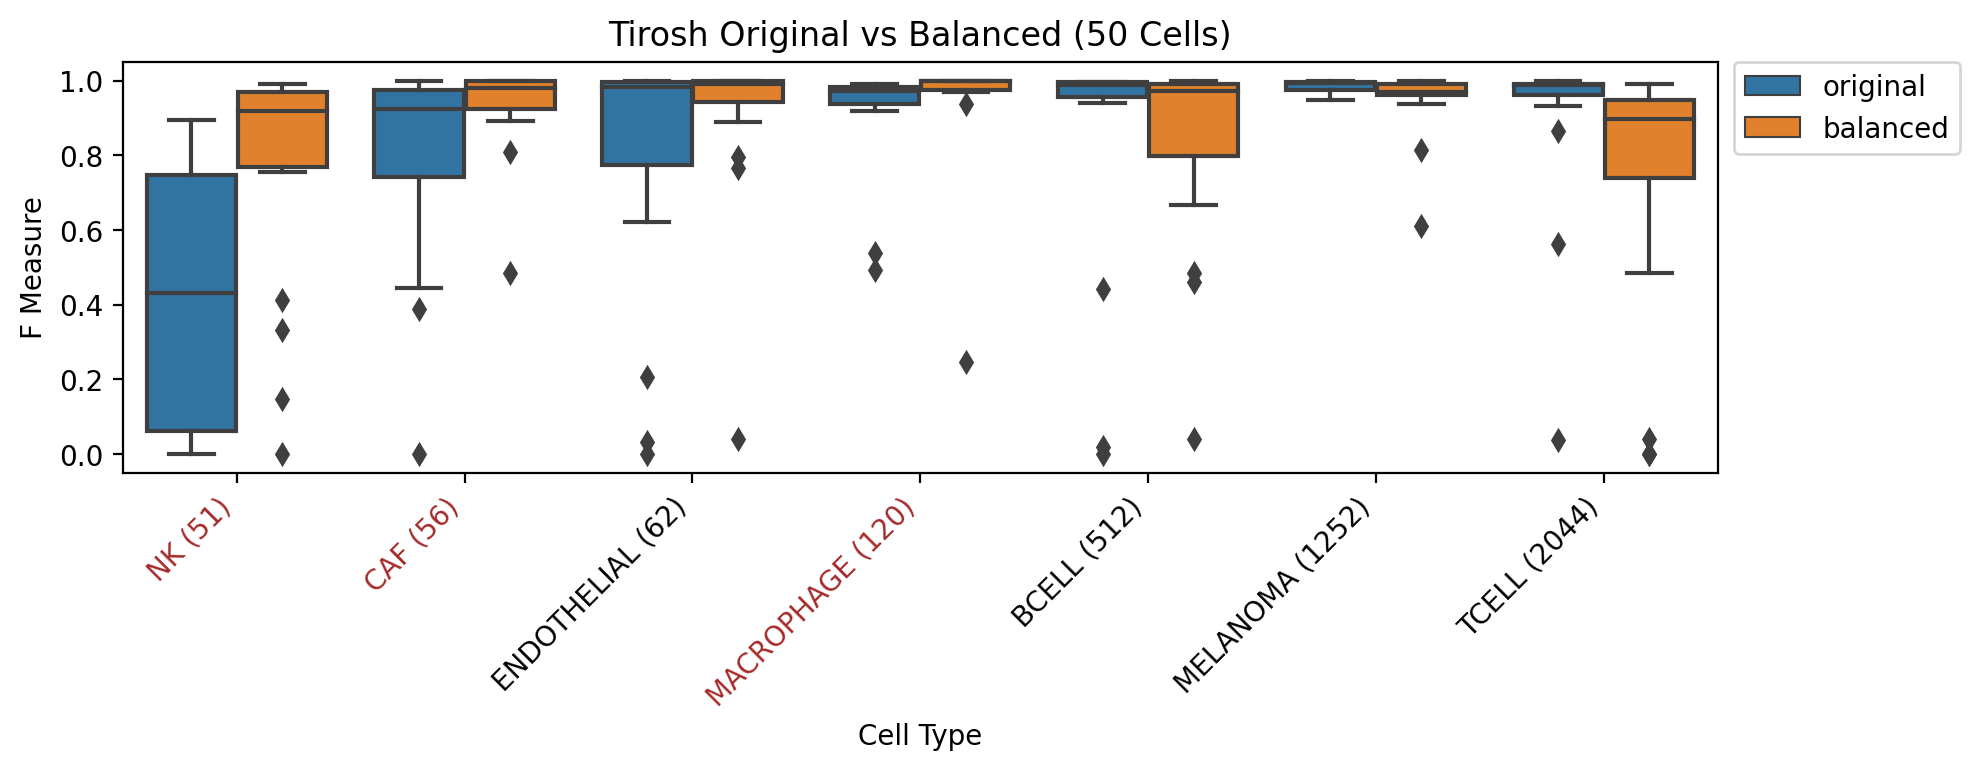

['LAmbDA', 'kNN9', 'scVI', 'SingleCellNet', 'NMC', 'scmapcell', 'SVM', 'singleR', 'ACTINN', 'LDA', 'scmapcluster', 'CHETAH', 'scPred', 'Cell_BLAST', 'RF', 'CaSTLe', 'scID', 'LDArej', 'SVMrej']


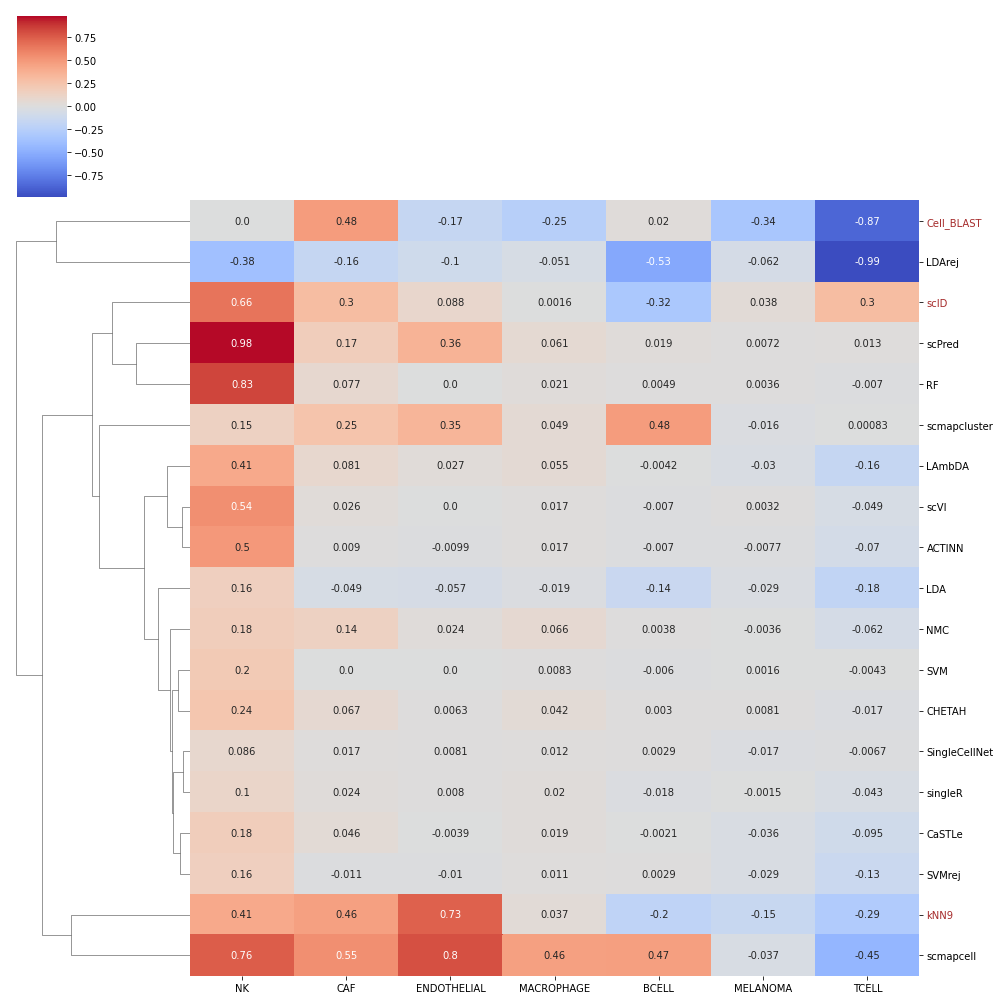

In [9]:
compare_subsampled('data/Tirosh_Melanoma_50.tsv')

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 700


,method,class,precision,recall,f1_score,support,specificity,cellprop
0,LAmbDA,ASTOCYTE,1.000000,0.96,0.979592,100,1.000000,0.142857
1,LAmbDA,IMMUNE,0.933962,0.99,0.961165,100,0.988333,0.142857
2,LAmbDA,NEOPLASTIC,0.941176,0.96,0.950495,100,0.990000,0.142857
3,LAmbDA,NEURON,0.989899,0.98,0.984925,100,0.998333,0.142857
4,LAmbDA,OLIGODENDROCYTE,1.000000,0.98,0.989899,100,1.000000,0.142857


--------NEURON--------
Group F-measures are different! p = 9.5367431640625e-06

--------VASCULAR--------
Group F-measures are not different, p = 0.06681060791015625

--------OLIGODENDROCYTE--------
Group F-measures are different! p = 0.024682998657226562

--------ASTOCYTE--------
Group F-measures are different! p = 0.027286529541015625

--------OPC--------
Group F-measures are not different, p = 0.6887187957763672

--------NEOPLASTIC--------
Group F-measures are not different, p = 0.9156036376953125

--------IMMUNE--------
Group F-measures are not different, p = 0.9997386932373047


Medians of the two groups are not different, p =  0.109375
Standard deviations of the two groups are not different, p =  0.53125
Variances of the two groups are not different, p =  0.40625


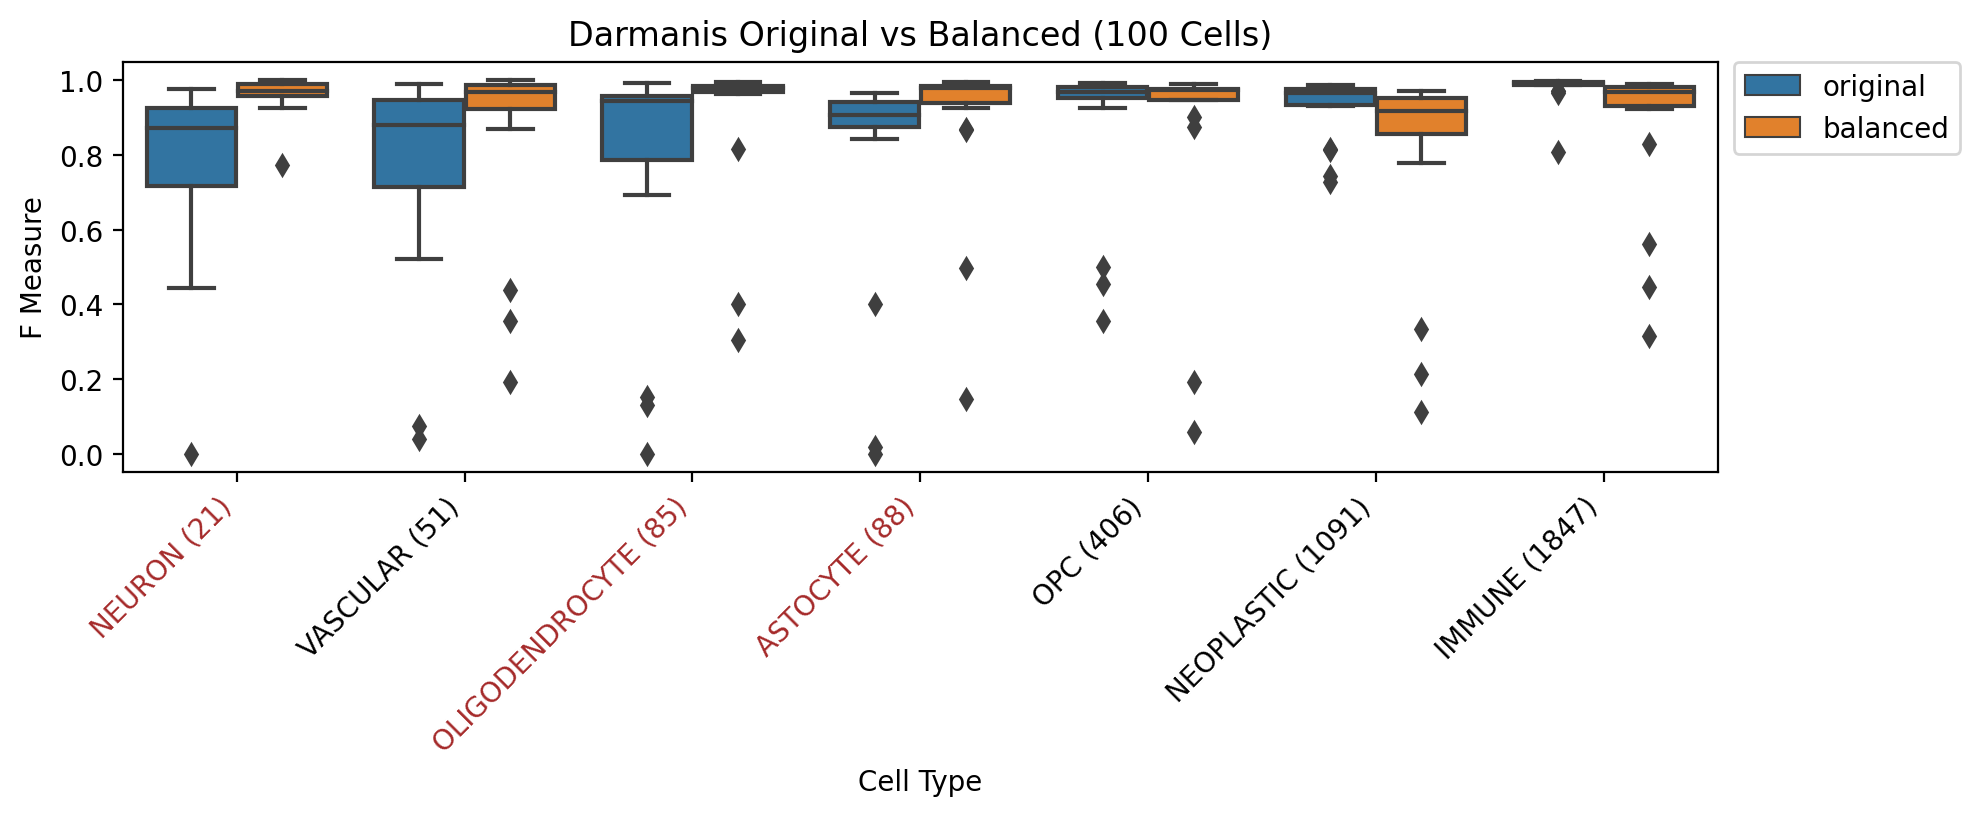

['scmapcell', 'SVMrej', 'LAmbDA', 'ACTINN', 'SVM', 'scID', 'NMC', 'kNN9', 'scVI', 'LDArej', 'LDA', 'CHETAH', 'scPred', 'Cell_BLAST', 'CaSTLe', 'RF', 'singleR', 'scmapcluster', 'SingleCellNet']


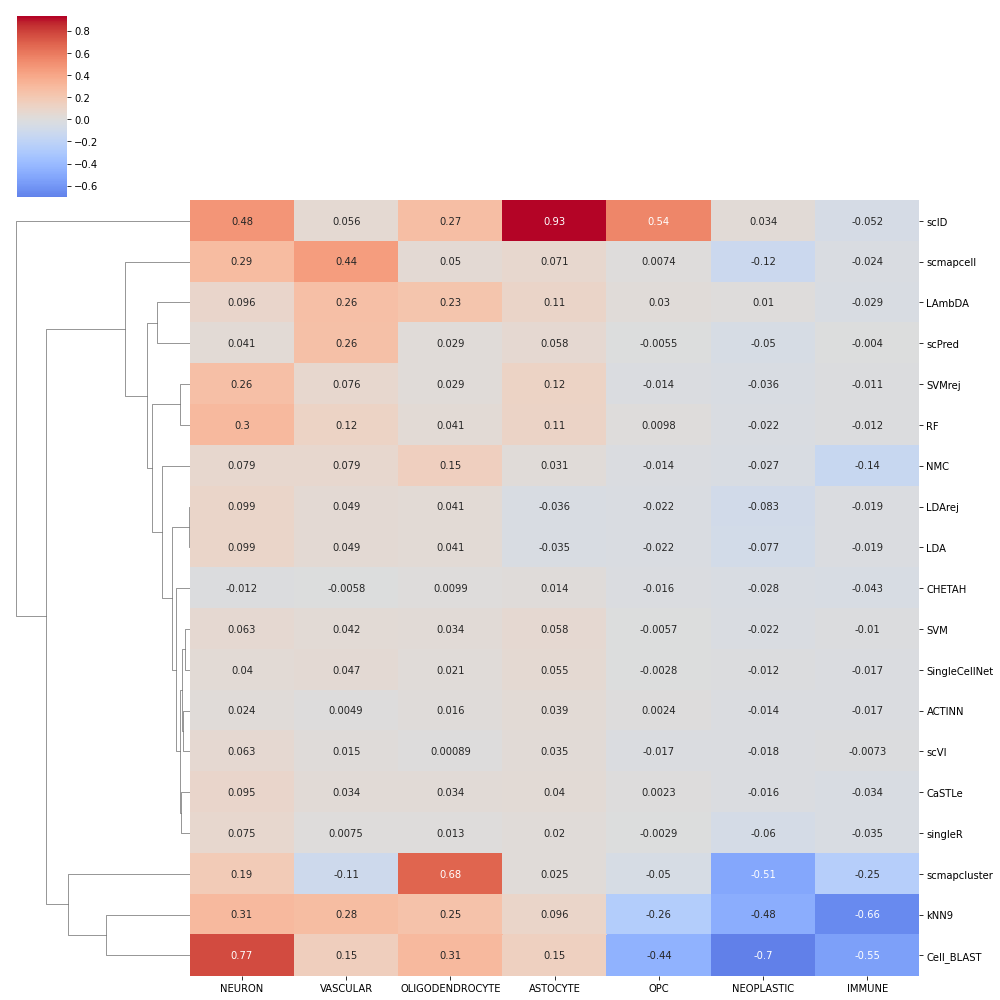

In [43]:
compare_subsampled('data/Tirosh_Melanoma_100.tsv')

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 1400


,method,class,precision,recall,f1_score,support,specificity,cellprop
0,LAmbDA,ASTOCYTE,1.000000,0.975,0.987342,200,1.000000,0.142857
1,LAmbDA,IMMUNE,0.980100,0.985,0.982544,200,0.996667,0.142857
2,LAmbDA,NEOPLASTIC,0.937198,0.970,0.953317,200,0.989167,0.142857
3,LAmbDA,NEURON,1.000000,1.000,1.000000,200,1.000000,0.142857
4,LAmbDA,OLIGODENDROCYTE,0.994975,0.990,0.992481,200,0.999167,0.142857


--------NEURON--------
Group F-measures are different! p = 0.000133514404296875

--------VASCULAR--------
Group F-measures are different! p = 0.04371452331542969

--------OLIGODENDROCYTE--------
Group F-measures are different! p = 0.024682998657226562

--------ASTOCYTE--------
Group F-measures are different! p = 0.01446533203125

--------OPC--------
Group F-measures are not different, p = 0.7025566101074219

--------NEOPLASTIC--------
Group F-measures are not different, p = 0.8949413299560547

--------IMMUNE--------
Group F-measures are not different, p = 0.9384059906005859


Medians of the two groups are not different, p =  0.0546875
Standard deviations of the two groups are not different, p =  0.234375
Variances of the two groups are not different, p =  0.1875


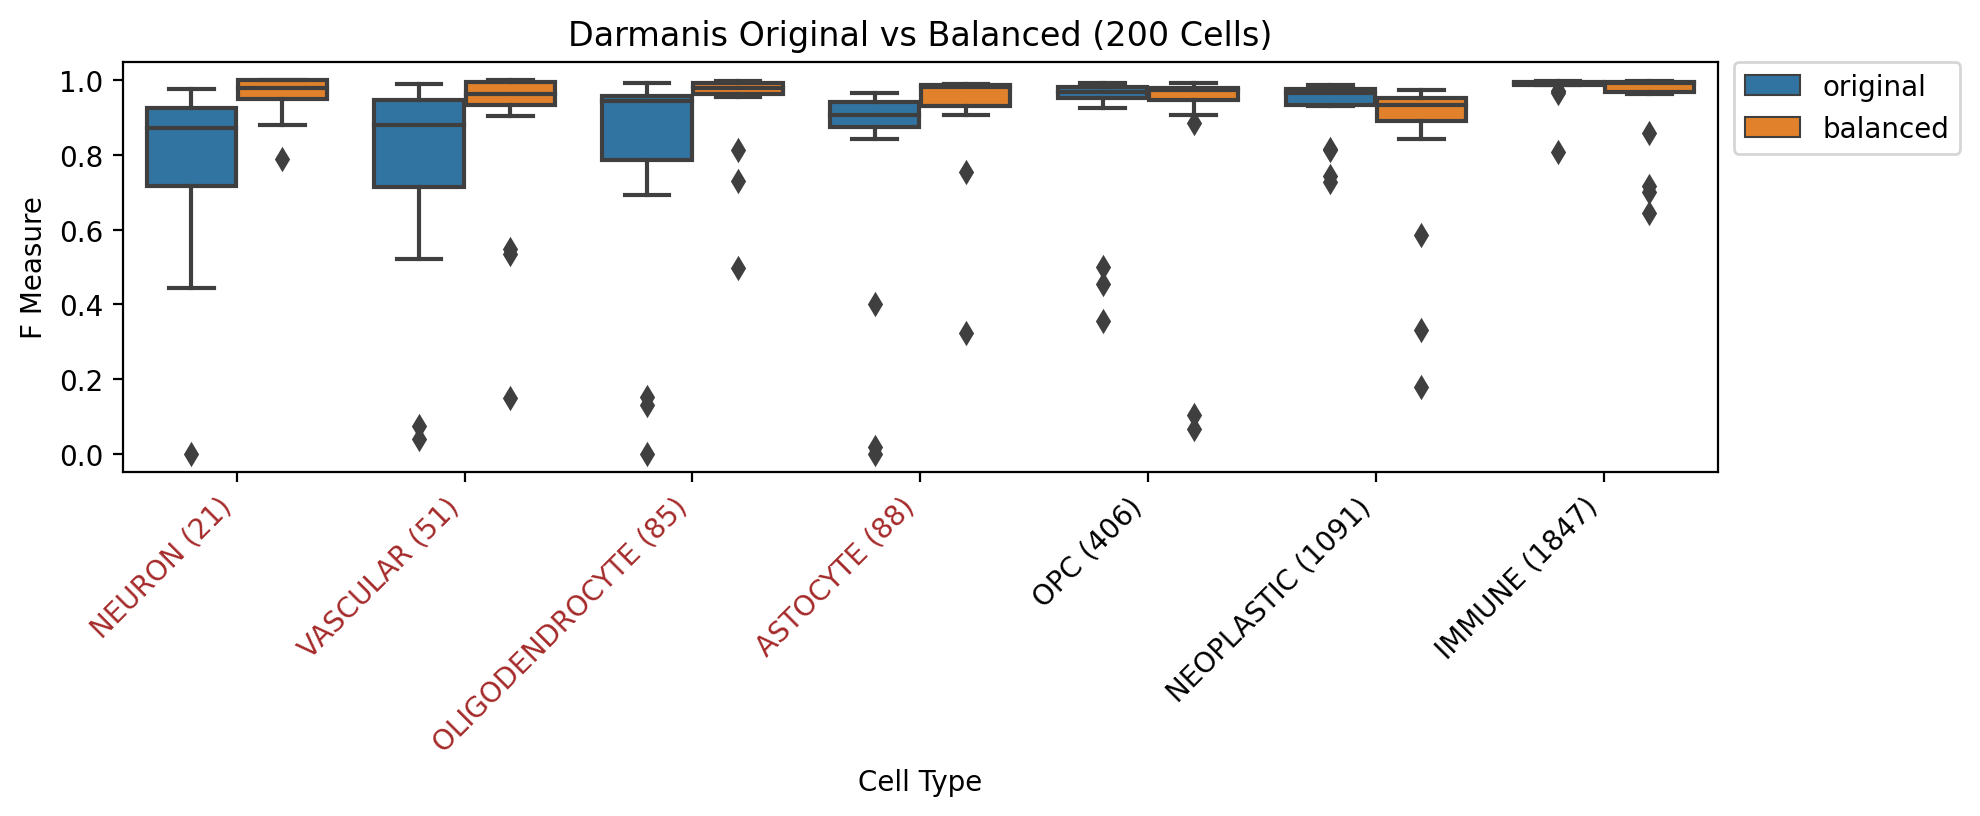

['scmapcell', 'SVMrej', 'LAmbDA', 'ACTINN', 'SVM', 'scID', 'NMC', 'kNN9', 'scVI', 'LDArej', 'LDA', 'CHETAH', 'scPred', 'Cell_BLAST', 'CaSTLe', 'RF', 'singleR', 'scmapcluster', 'SingleCellNet']


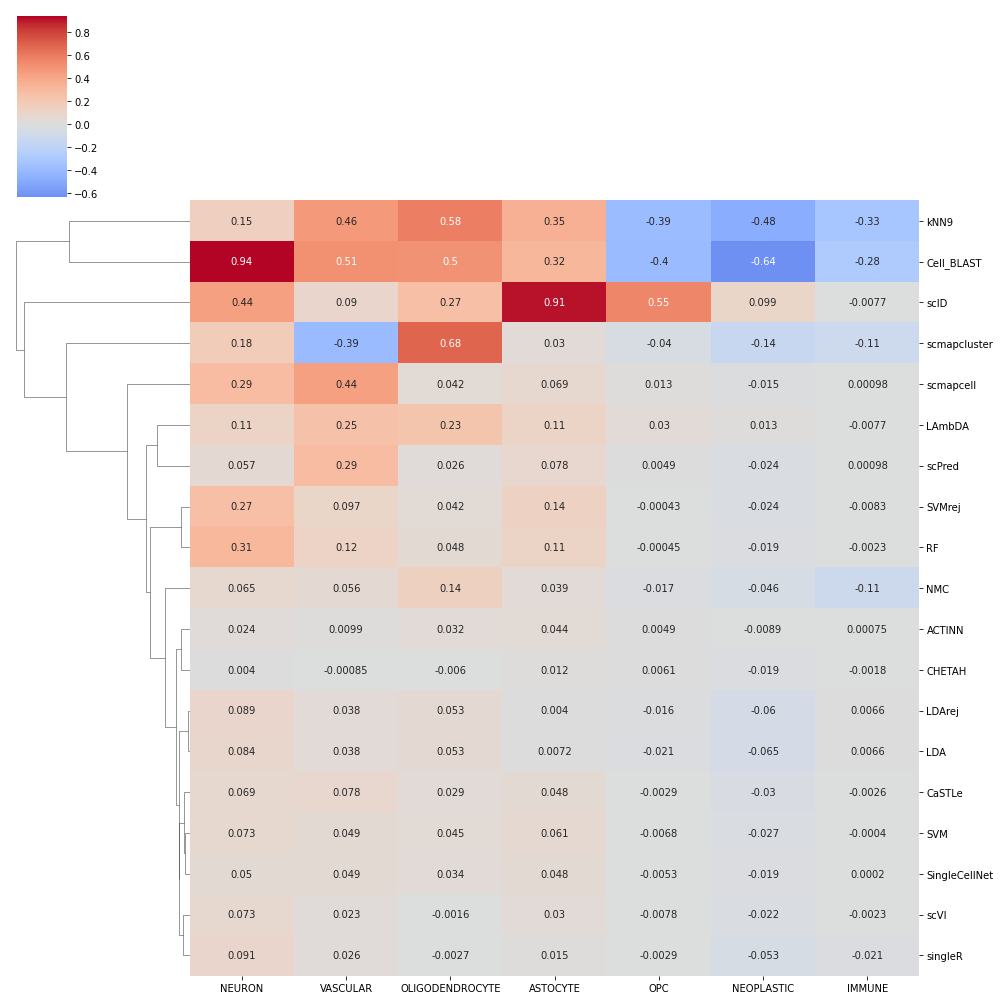

In [44]:
compare_subsampled('data/Tirosh_Melanoma_200.tsv')

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 2800


,method,class,precision,recall,f1_score,support,specificity,cellprop
0,LAmbDA,ASTOCYTE,1.000000,0.9975,0.998748,400,1.000000,0.142857
1,LAmbDA,IMMUNE,0.992500,0.9925,0.992500,400,0.998750,0.142857
2,LAmbDA,NEOPLASTIC,0.965686,0.9850,0.975248,400,0.994167,0.142857
3,LAmbDA,NEURON,1.000000,1.0000,1.000000,400,1.000000,0.142857
4,LAmbDA,OLIGODENDROCYTE,0.997506,1.0000,0.998752,400,0.999583,0.142857


--------NEURON--------
Group F-measures are different! p = 3.62396240234375e-05

--------VASCULAR--------
Group F-measures are different! p = 0.011115619143009622

--------OLIGODENDROCYTE--------
Group F-measures are different! p = 0.00308990478515625

--------ASTOCYTE--------
Group F-measures are different! p = 0.000209808349609375

--------OPC--------
Group F-measures are not different, p = 0.3690452575683594

--------NEOPLASTIC--------
Group F-measures are not different, p = 0.5856075286865234

--------IMMUNE--------
Group F-measures are not different, p = 0.8623294830322266


Medians of the two groups are not different, p =  0.0546875
Standard deviations of the two groups are not different, p =  0.1484375
Variances of the two groups are not different, p =  0.109375


/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


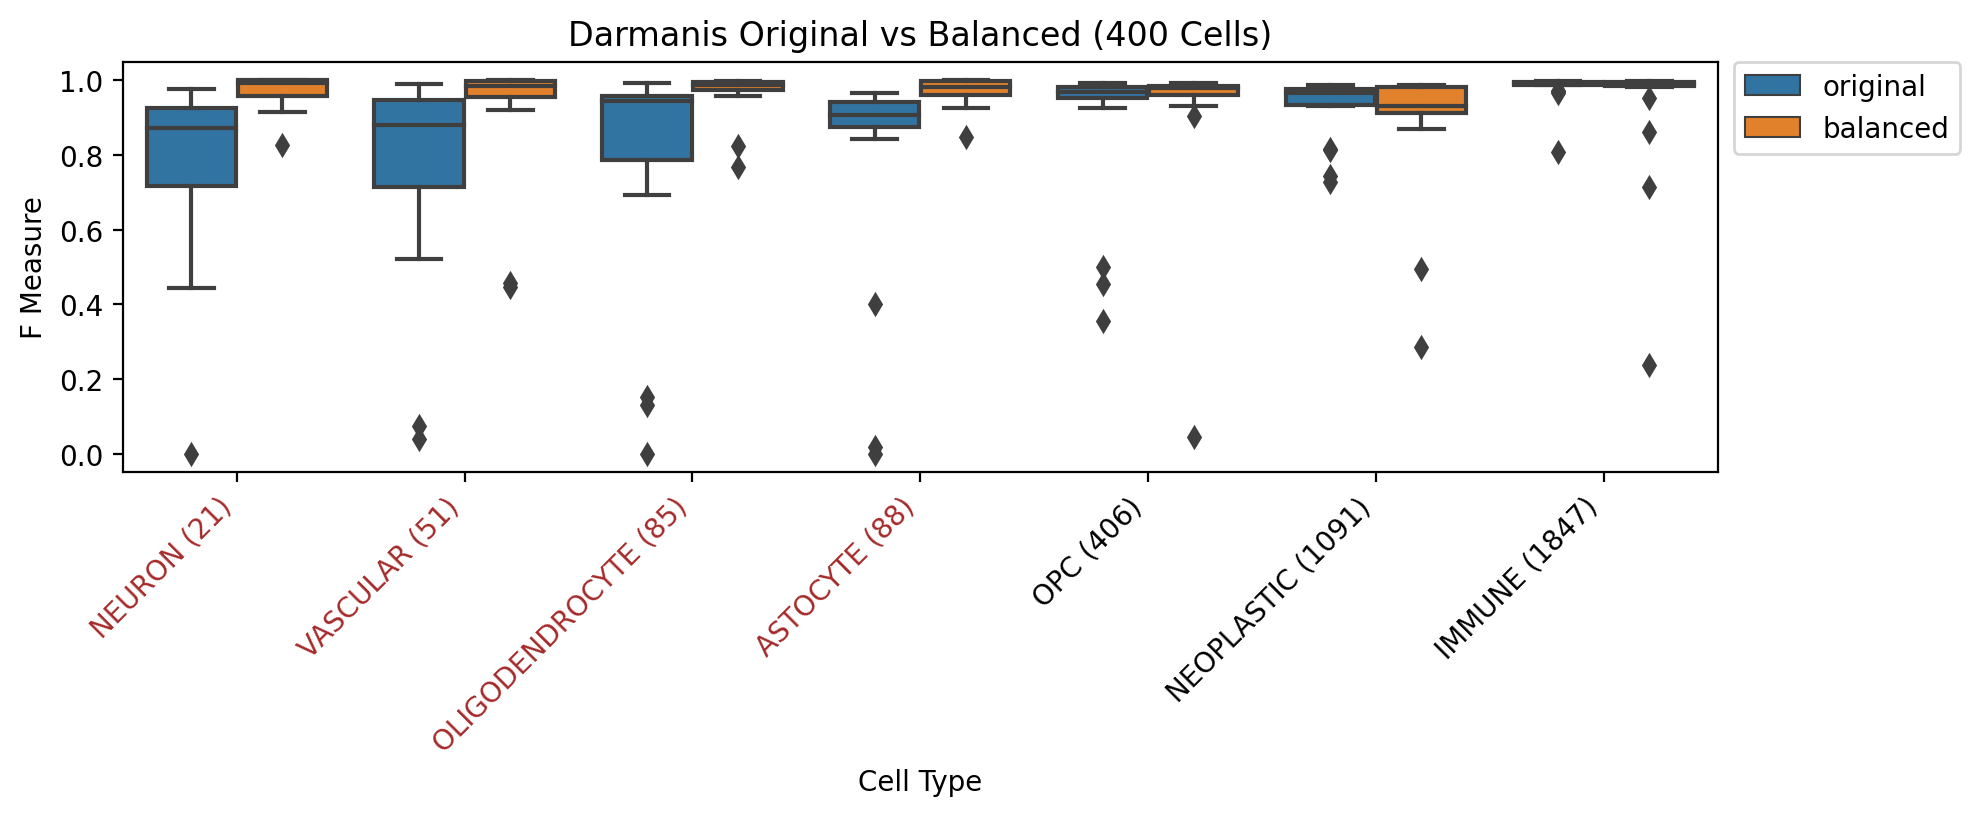

['scmapcell', 'SVMrej', 'LAmbDA', 'ACTINN', 'SVM', 'scID', 'NMC', 'kNN9', 'scVI', 'LDArej', 'LDA', 'CHETAH', 'scPred', 'Cell_BLAST', 'CaSTLe', 'RF', 'singleR', 'scmapcluster', 'SingleCellNet']


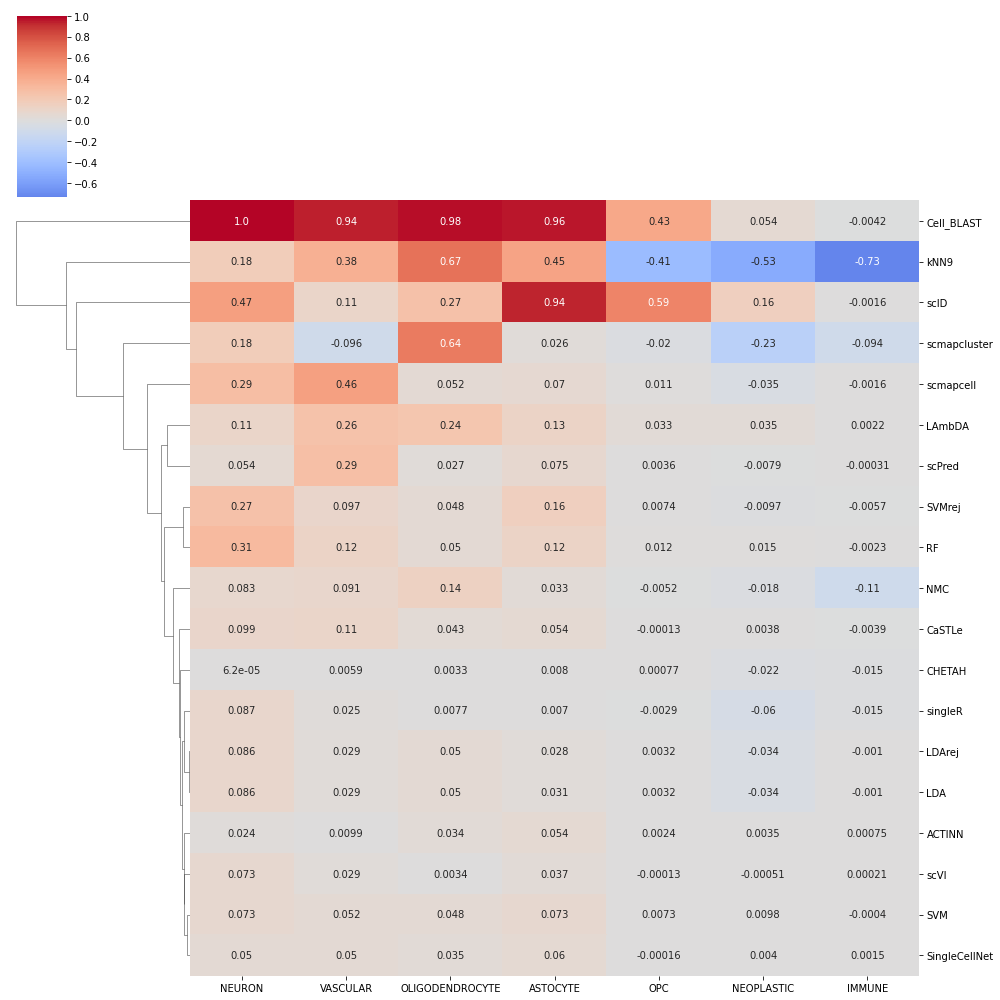

In [45]:
compare_subsampled('data/Tirosh_Melanoma_400.tsv')

{'NK', 'BCELL', 'ENDO', 'CAF', 'MACRO', 'TCELL', 'TUMOR'}


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 5600


,method,class,precision,recall,f1_score,support,specificity,cellprop
0,LAmbDA,BCELL,0.993695,0.98500,0.989328,800,0.998958,0.142857
1,LAmbDA,CAF,1.000000,1.00000,1.000000,800,1.000000,0.142857
2,LAmbDA,ENDOTHELIAL,1.000000,1.00000,1.000000,800,1.000000,0.142857
3,LAmbDA,MACROPHAGE,0.996264,1.00000,0.998129,800,0.999375,0.142857
4,LAmbDA,MELANOMA,1.000000,0.99625,0.998121,800,1.000000,0.142857


--------NK--------
Group F-measures are different! p = 1.9073486328125e-06

--------CAF--------
Group F-measures are different! p = 0.00031460191540566297

--------ENDOTHELIAL--------
Group F-measures are different! p = 0.0013449631602190642

--------MACROPHAGE--------
Group F-measures are different! p = 0.000209808349609375

--------BCELL--------
Group F-measures are not different, p = 0.1660327911376953

--------MELANOMA--------
Group F-measures are different! p = 0.027286529541015625

--------TCELL--------
Group F-measures are not different, p = 0.47649192810058594


Medians of the two groups are not different, p =  0.0546875
Standard deviations of the two groups are different, p =  0.0078125
Variances of the two groups are different, p =  0.0078125


/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


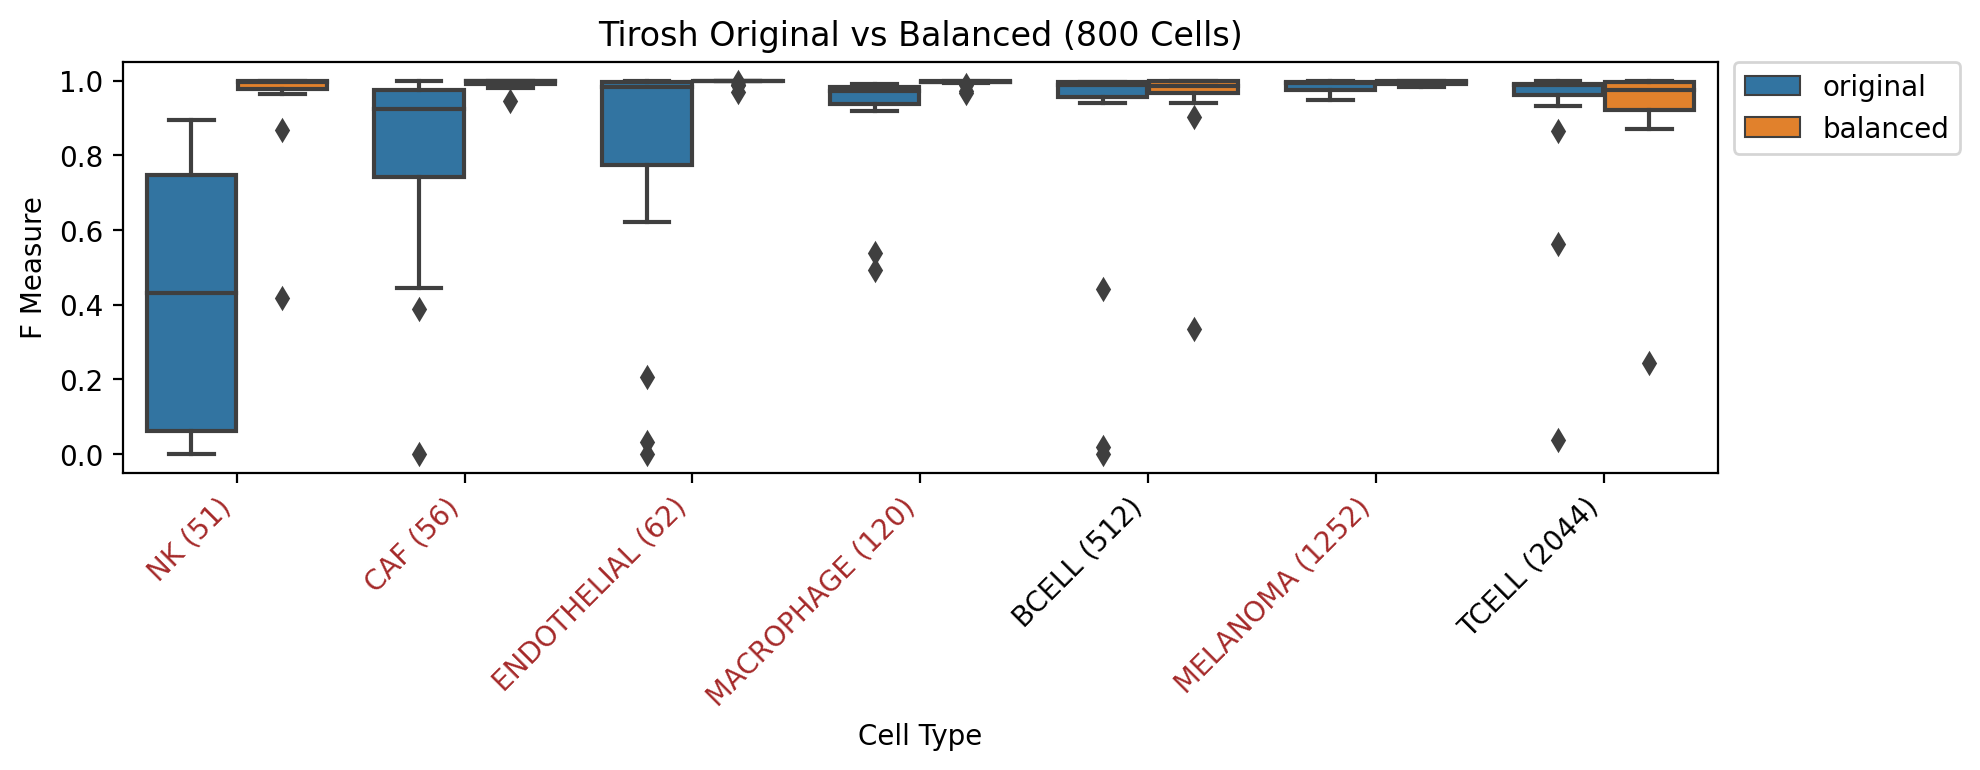

['LAmbDA', 'kNN9', 'scVI', 'SingleCellNet', 'NMC', 'scmapcell', 'SVM', 'singleR', 'ACTINN', 'LDA', 'scmapcluster', 'CHETAH', 'scPred', 'Cell_BLAST', 'RF', 'CaSTLe', 'scID', 'LDArej', 'SVMrej']


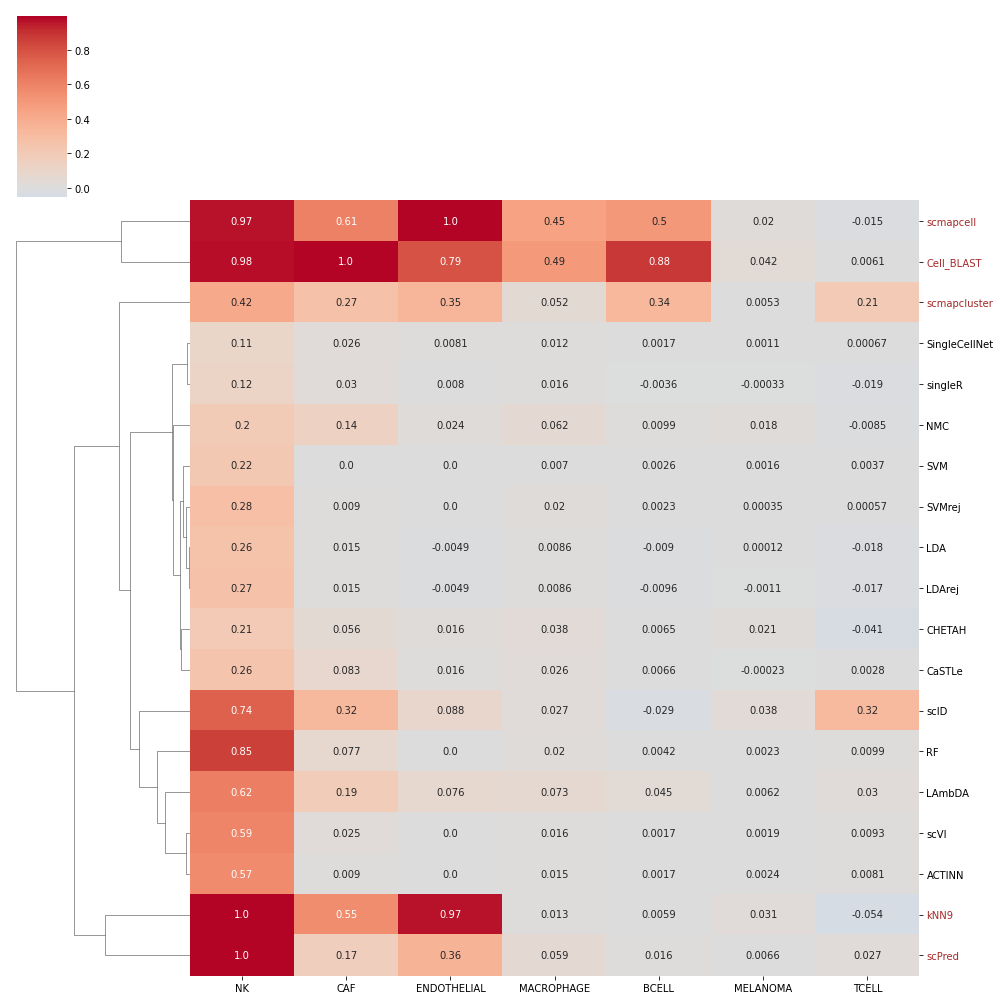

In [19]:
compare_subsampled('data/Tirosh_Melanoma_800.tsv')

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 27200


,method,class,precision,recall,f1_score,support,specificity,cellprop
0,LAmbDA,ALVEOLAR_CELL,0.920245,0.750000,0.826446,1600,0.995938,0.0588235
1,LAmbDA,BASAL_CELLS,0.991940,1.000000,0.995954,1600,0.999492,0.0588235
2,LAmbDA,B_CELLS,0.880862,0.868750,0.874764,1600,0.992656,0.0588235
3,LAmbDA,CANCER_CELLS,0.861064,0.960625,0.908124,1600,0.990313,0.0588235
4,LAmbDA,DENDRITIC_CELLS,0.921179,0.840000,0.878719,1600,0.995508,0.0588235


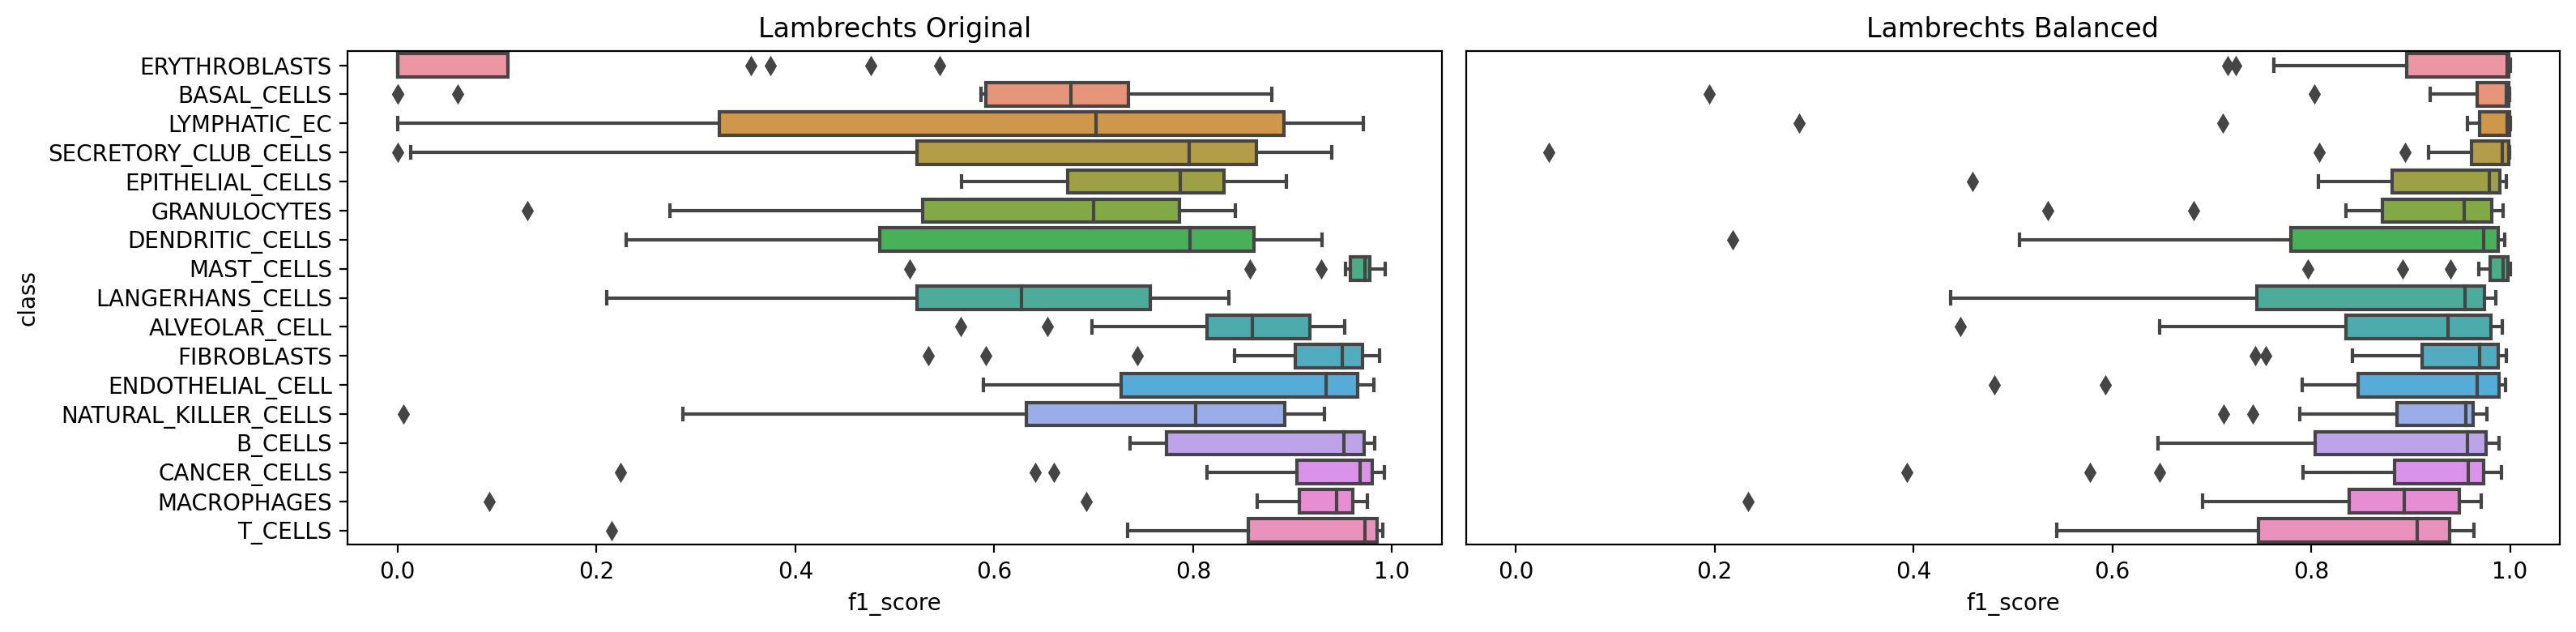

--------ERYTHROBLASTS--------
Group F-measures are different! p = 7.62939453125e-06

--------BASAL_CELLS--------
Group F-measures are different! p = 0.0005340576171875

--------LYMPHATIC_EC--------
Group F-measures are different! p = 0.00067138671875

--------SECRETORY_CLUB_CELLS--------
Group F-measures are different! p = 0.00128936767578125

--------EPITHELIAL_CELLS--------
Group F-measures are different! p = 0.0008392333984375

--------GRANULOCYTES--------
Group F-measures are different! p = 0.00067138671875

--------DENDRITIC_CELLS--------
Group F-measures are not different, p = 0.0601043701171875

--------MAST_CELLS--------
Group F-measures are different! p = 0.0284423828125

--------LANGERHANS_CELLS--------
Group F-measures are different! p = 0.00157928466796875

--------ALVEOLAR_CELL--------
Group F-measures are not different, p = 0.054443359375

--------FIBROBLASTS--------
Group F-measures are not different, p = 0.13166046142578125

--------ENDOTHELIAL_CELL--------
Group F-meas

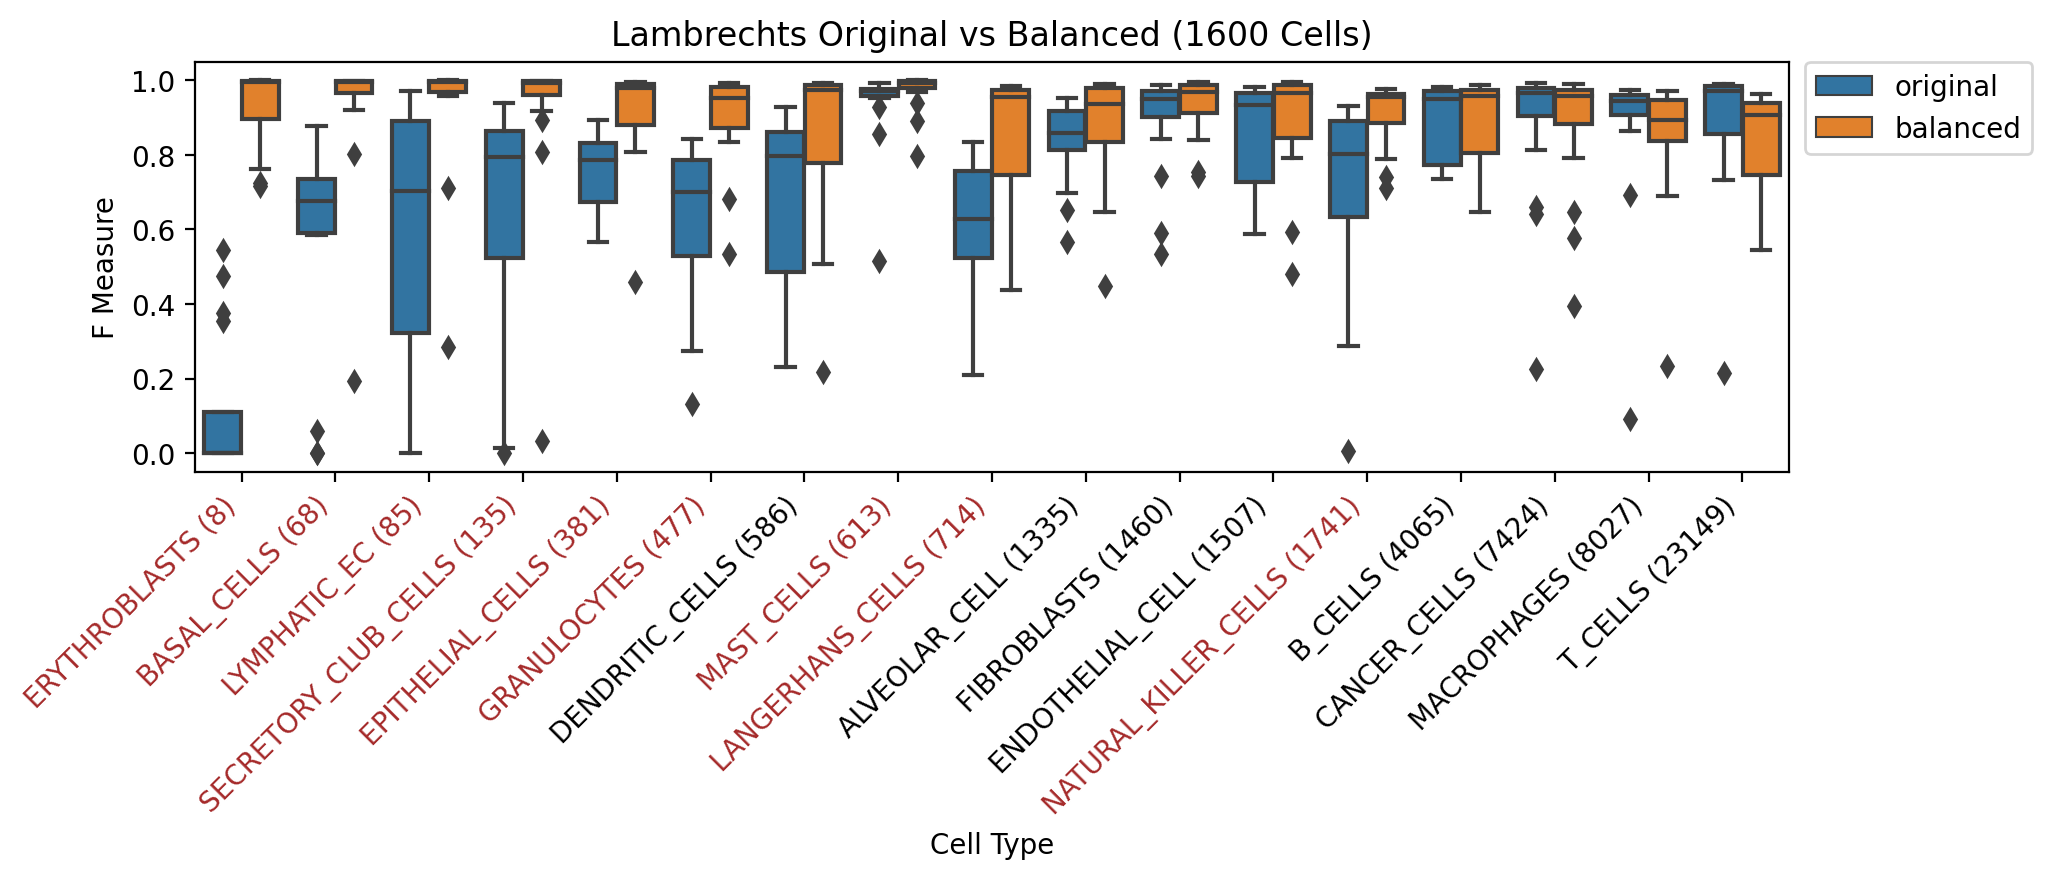

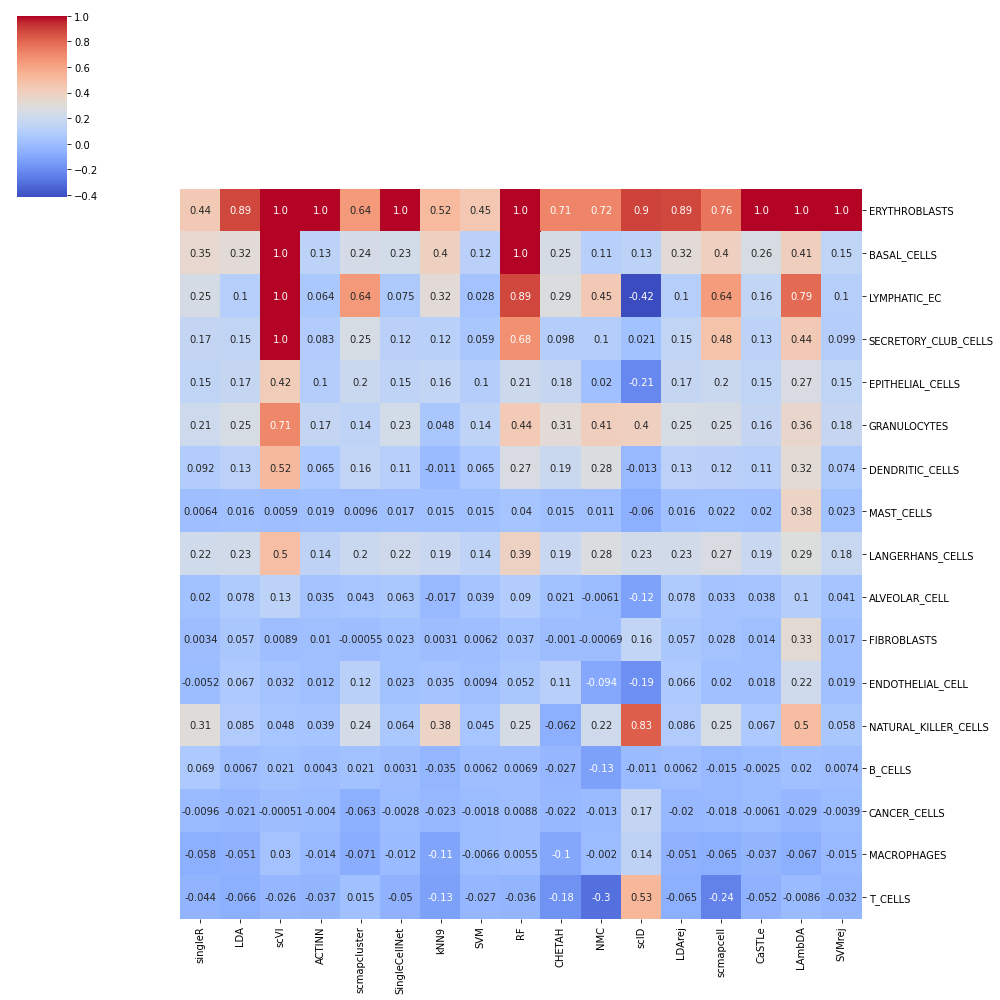

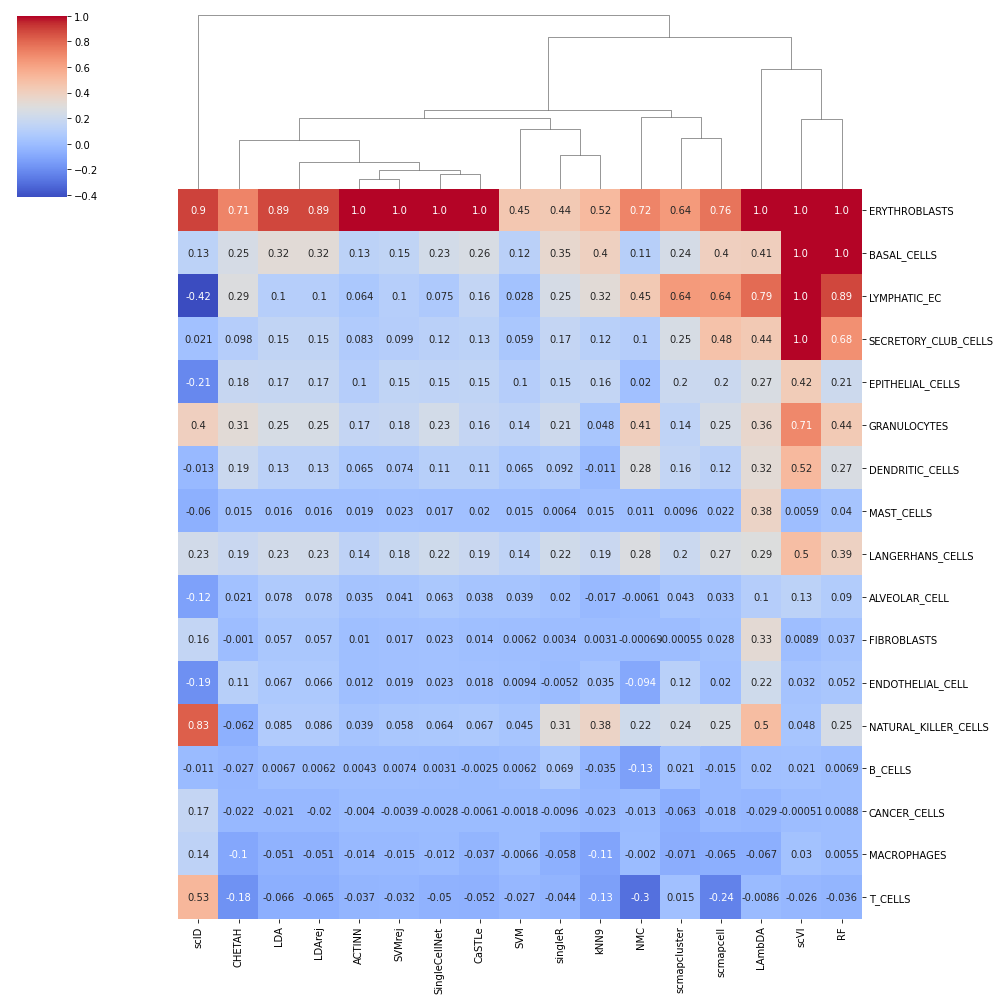

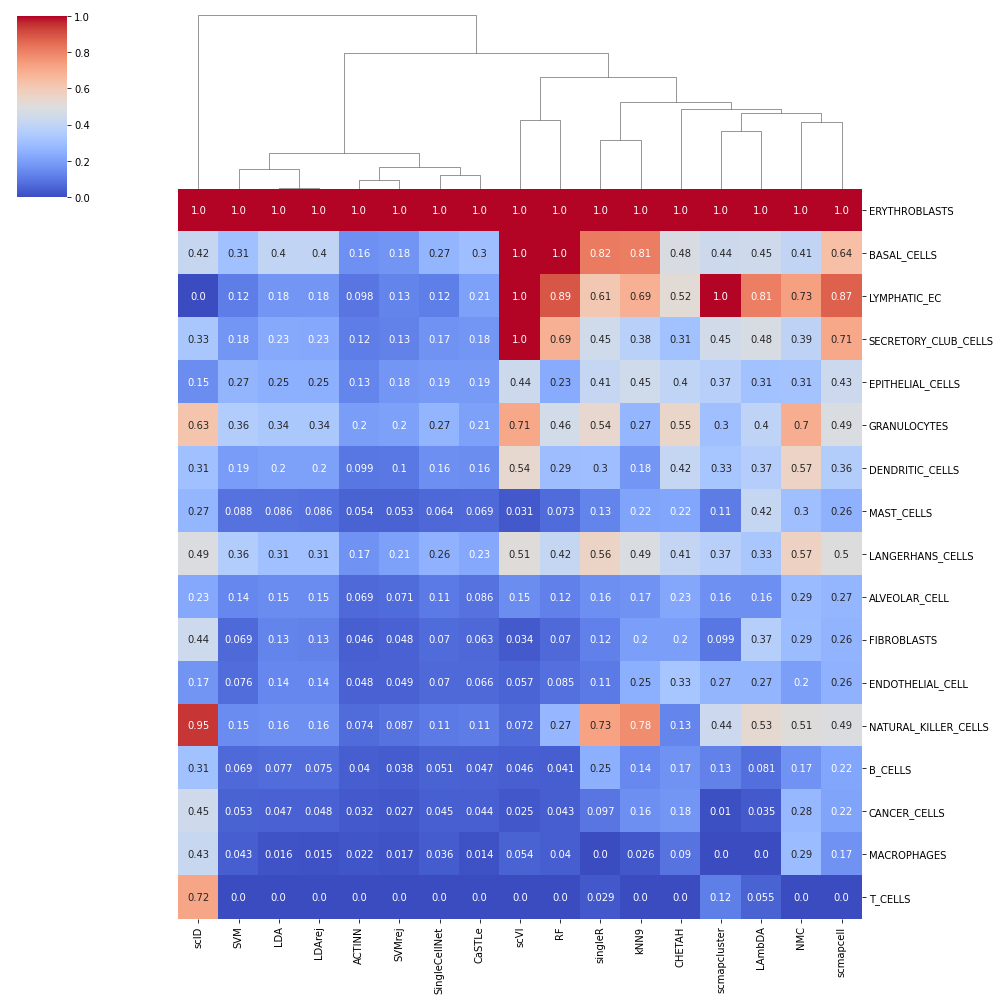

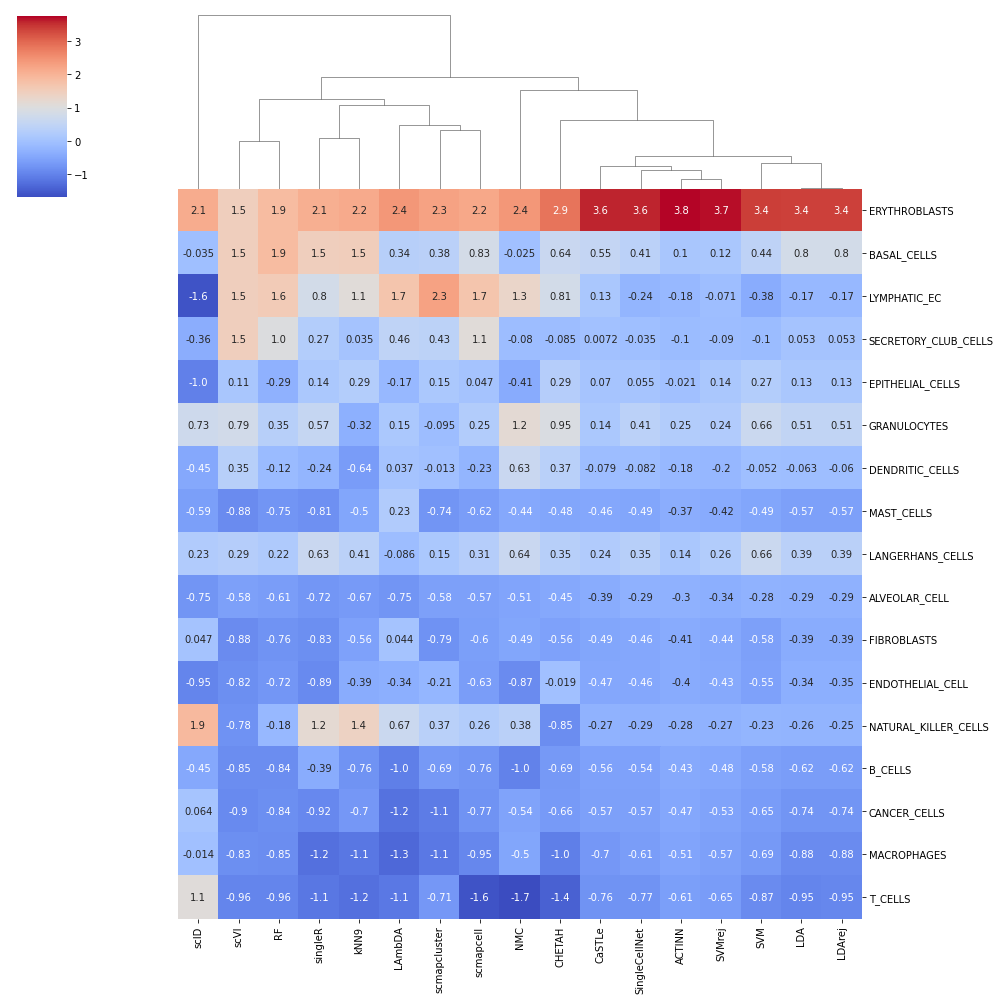

In [102]:
compare_subsampled('data/Lambrechts_LC_1600.tsv')

In [4]:
input_files = listdir('./performance')

subsamples = {}

all_subsamples = pd.DataFrame()

for file in input_files:
    #only operate on tsv files
    if file[-4:] != '.tsv':
        continue 
    print(file)
    
    # store the data according to the number of cells
    num_cells = file.split('_')[2]
    subsamples[num_cells] = pd.read_csv(f'./performance/{file}', sep='\t').drop(columns='sorting')
    all_subsamples = all_subsamples.append(subsamples[num_cells],ignore_index=True)

display(all_subsamples)
display(fulldf)

Lambrechts_LC_100.tsv
Lambrechts_LC_200.tsv
Lambrechts_LC_400.tsv
Lambrechts_LC_800.tsv
Lambrechts_LC_1600.tsv
Lambrechts_LC_50.tsv


,method,class,precision,recall,f1_score,support,specificity,cellprop,dataset
0,SVM,ERYTHROBLASTS,0.990099,1.00,0.995025,100,0.999375,0.058824,balanced
1,LDA,ERYTHROBLASTS,0.784000,0.98,0.871111,100,0.983125,0.058824,balanced
2,LDArej,ERYTHROBLASTS,0.844828,0.98,0.907407,100,0.988750,0.058824,balanced
3,ACTINN,ERYTHROBLASTS,0.990099,1.00,0.995025,100,0.999375,0.058824,balanced
4,CaSTLe,ERYTHROBLASTS,0.961538,1.00,0.980392,100,0.997500,0.058824,balanced
...,...,...,...,...,...,...,...,...,...
1814,scmapcell,T_CELLS,1.000000,0.22,0.360656,50,1.000000,0.058824,balanced
1815,NMC,T_CELLS,0.611940,0.82,0.700855,50,0.967500,0.058824,balanced
1816,singleR,T_CELLS,0.886364,0.78,0.829787,50,0.993750,0.058824,balanced
1817,scmapcluster,T_CELLS,0.823529,0.84,0.831683,50,0.988750,0.058824,balanced


,method,class,precision,recall,f1_score,support,specificity,cellprop,dataset
296,scVI,ERYTHROBLASTS,0.000000,0.000000,0.000000,8.0,1.000000,0.000155,original
219,LDArej,ERYTHROBLASTS,0.100000,0.125000,0.111111,8.0,0.999826,0.000155,original
239,NMC,ERYTHROBLASTS,0.003660,1.000000,0.007293,8.0,0.957927,0.000155,original
200,LDA,ERYTHROBLASTS,0.100000,0.125000,0.111111,8.0,0.999826,0.000155,original
258,kNN9,ERYTHROBLASTS,0.384615,0.625000,0.476190,8.0,0.999845,0.000155,original
...,...,...,...,...,...,...,...,...,...
402,CaSTLe,T_CELLS,0.975691,0.995248,0.985373,23149.0,0.979948,0.447108,original
421,CHETAH,T_CELLS,0.985579,0.755799,0.855529,23149.0,0.991057,0.447108,original
441,scID,T_CELLS,0.965292,0.121344,0.215588,23149.0,0.996472,0.447108,original
286,ACTINN,T_CELLS,0.984855,0.994427,0.989618,23149.0,0.987634,0.447108,original


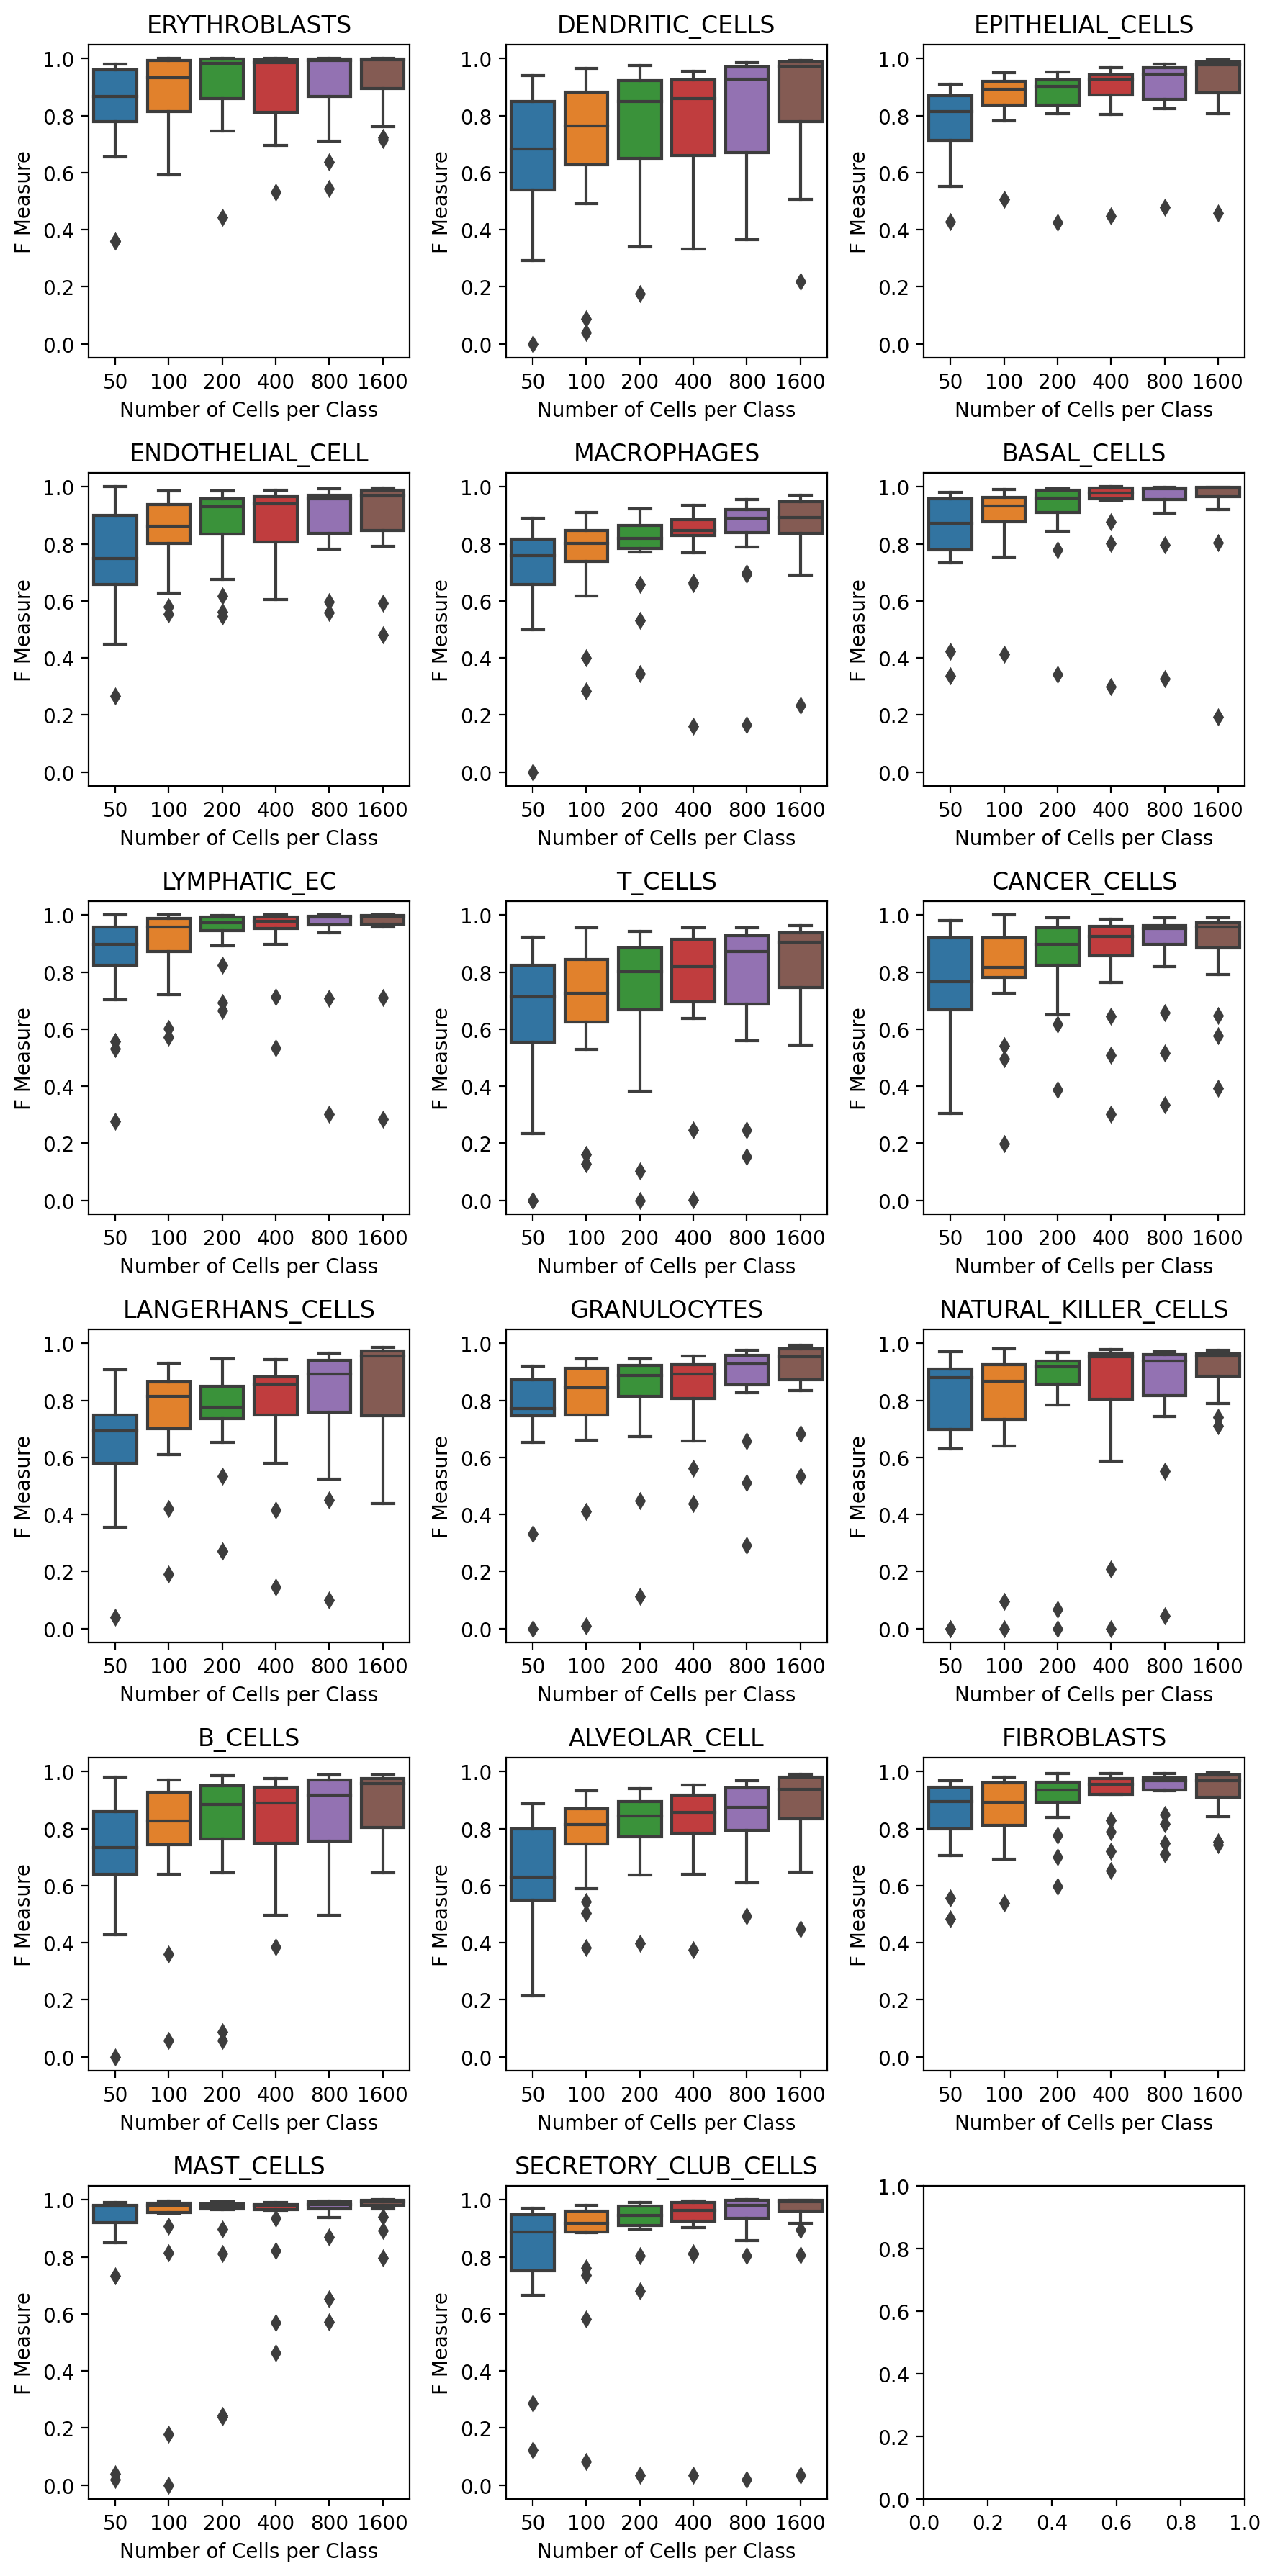

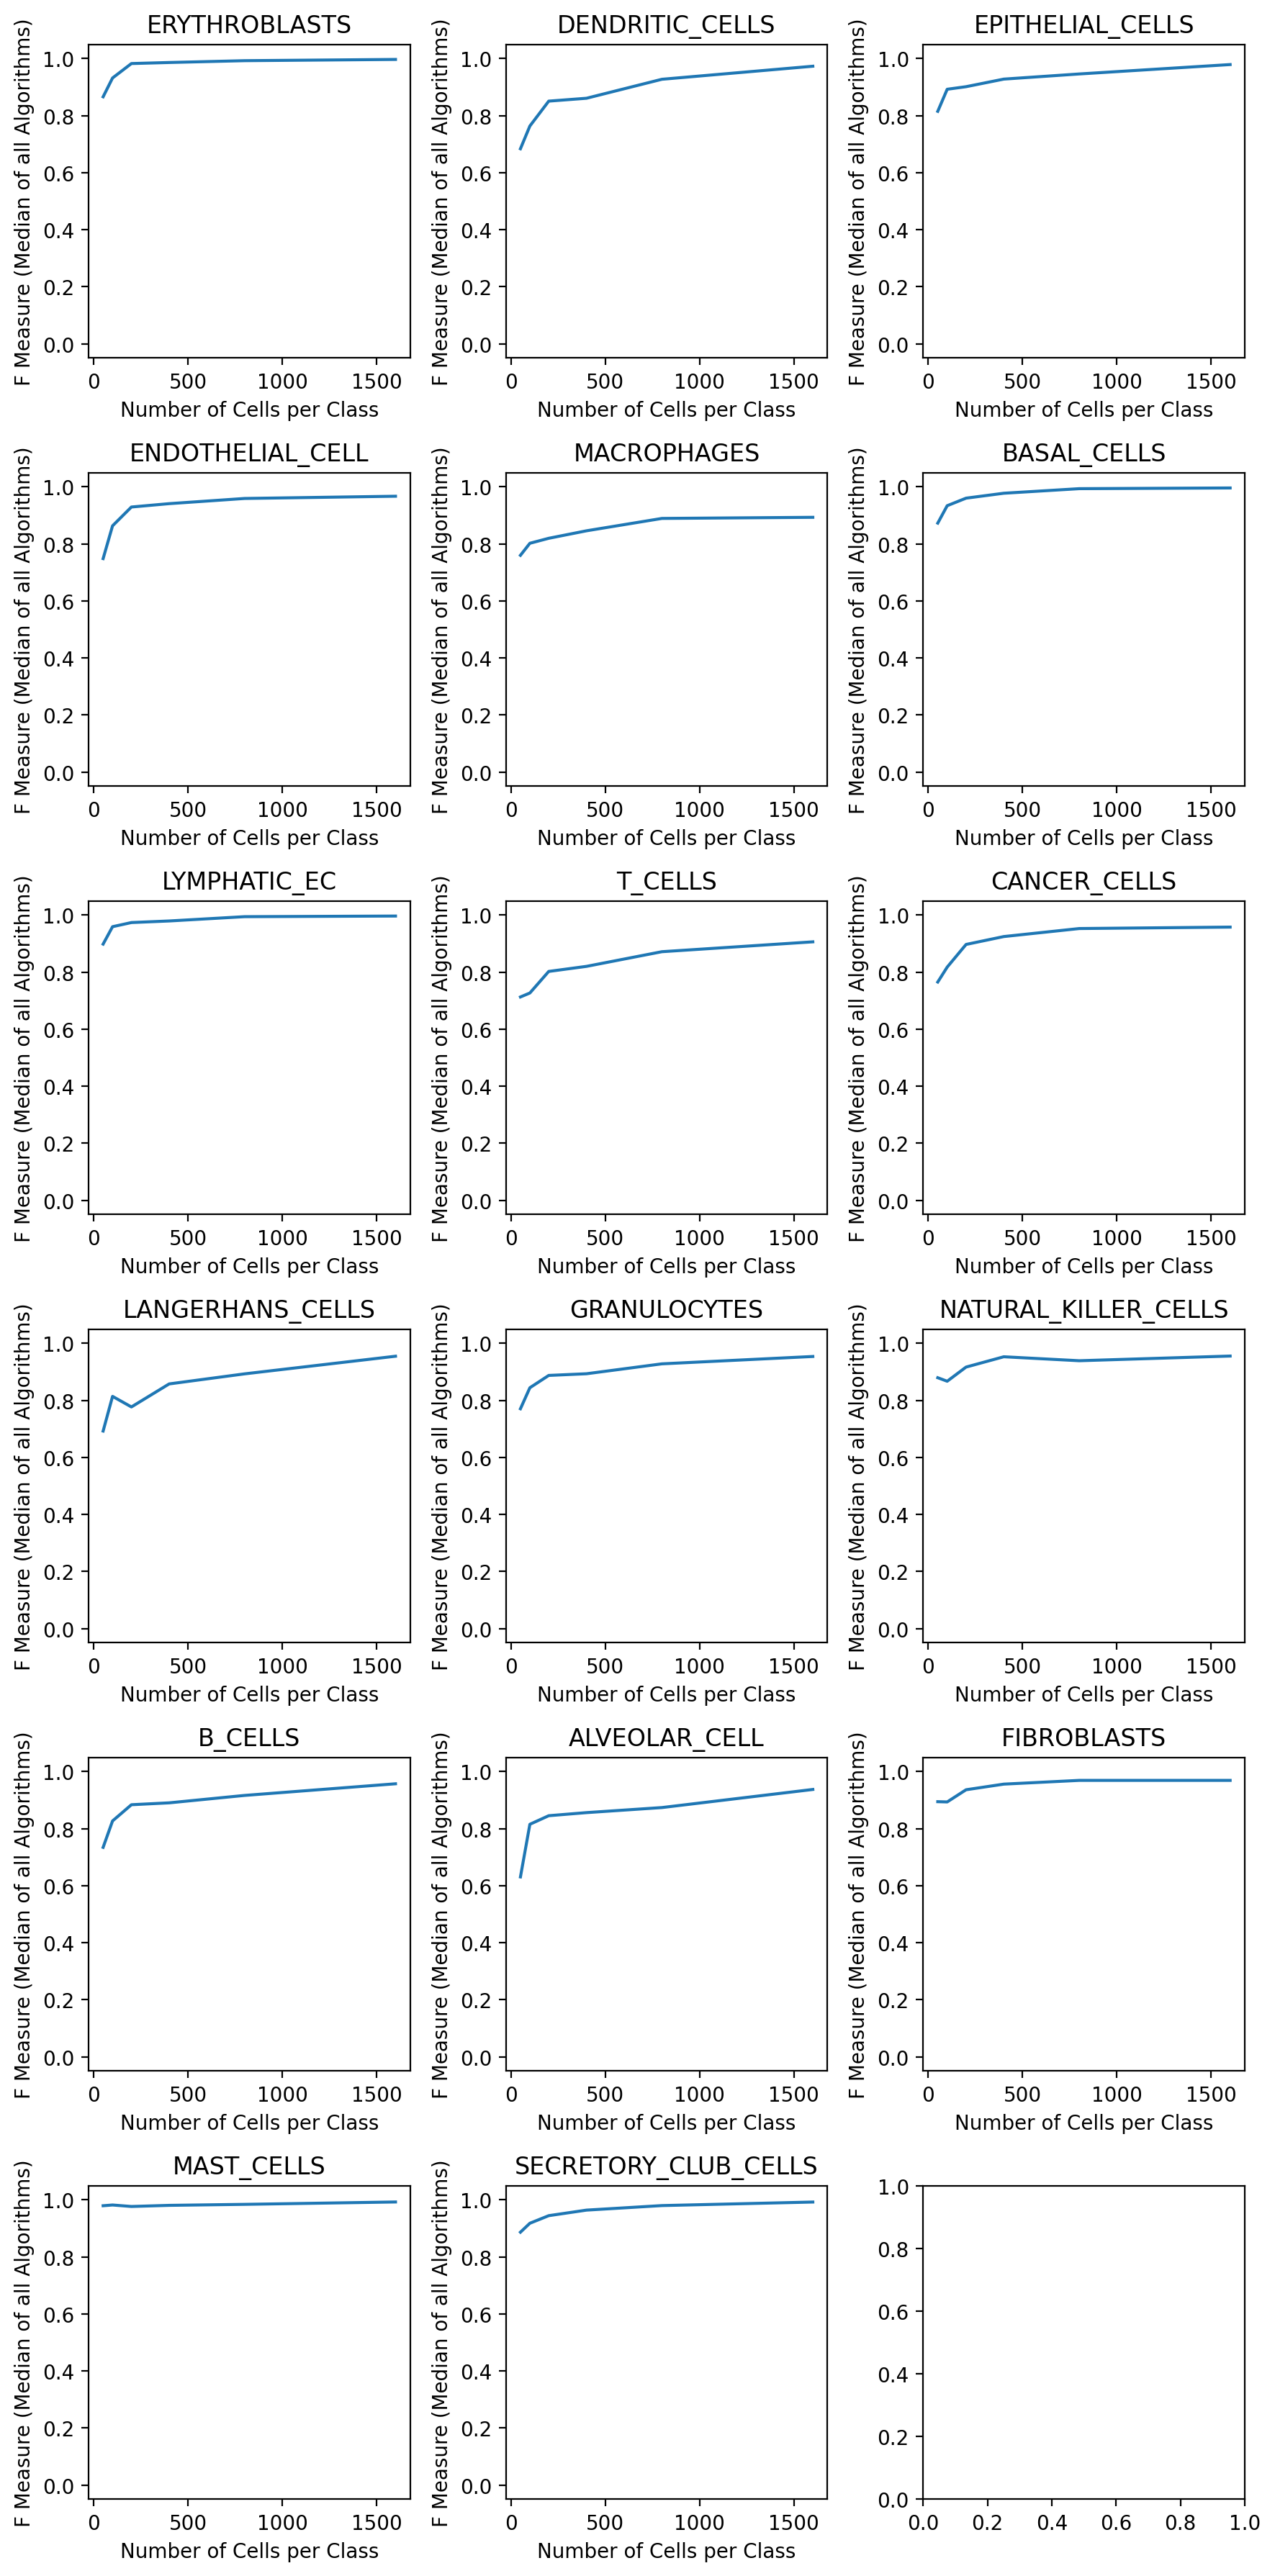

In [5]:
cell_types = list(set(all_subsamples['class']))
fig, axes = plt.subplots(6,3,dpi=200)
lfig, laxes = plt.subplots(6,3,dpi=200)

#for each cell type, make a subplot
for cell_type, ax, lax in zip(cell_types,axes.flatten(),laxes.flatten()):
    
    #select only those cells in the cell_type
    tempdf = all_subsamples[all_subsamples['class']==cell_type]
    bxplt = sns.boxplot(y='f1_score',
                        x='support',
                        data=tempdf,
                        ax=ax
                       )
    bxplt.set_ylim(-0.05,1.05)
    bxplt.set_ylabel('F Measure')
    bxplt.set_xlabel('Number of Cells per Class')
    bxplt.set_title(cell_type)
    
    # take the mean of all algorithms for a lineplot
    tempdf = tempdf.groupby(by='support').median()
    tempdf = tempdf.reset_index()
    #display(tempdf)
    lnplt = sns.lineplot(y='f1_score',
                         x='support',
                         data=tempdf, 
                         ax=lax
                        )
    lnplt.set_ylim(-0.05,1.05)
    lnplt.set_ylabel('F Measure (Median of all Algorithms)')
    lnplt.set_xlabel('Number of Cells per Class')
    lnplt.set_title(cell_type)

fig.set_figheight(18)
fig.set_figwidth(9)
fig.tight_layout()
lfig.set_figheight(18)
lfig.set_figwidth(9)
lfig.tight_layout()
plt.show()

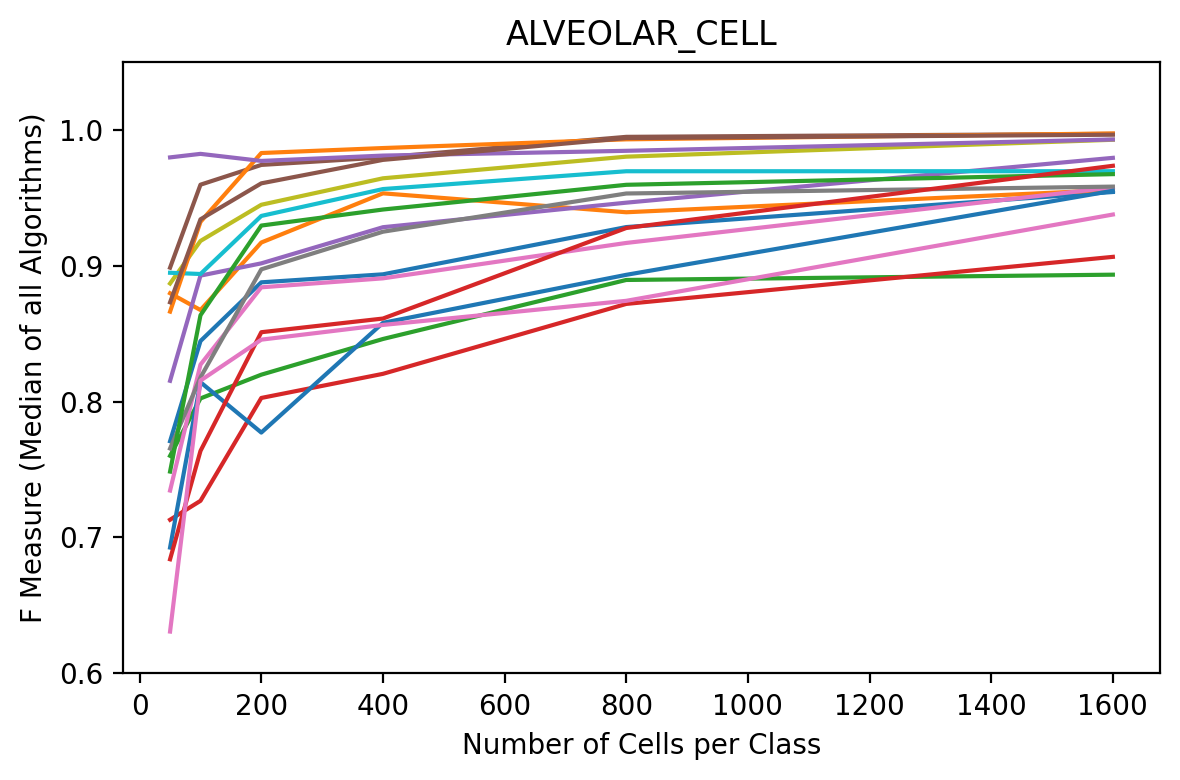

In [83]:
cell_types = list(set(all_subsamples['class']))
fig, lax = plt.subplots(1,1,dpi=200)

#for each cell type, make a subplot
for cell_type in cell_types:
    
    #select only those cells in the cell_type
    tempdf = all_subsamples[all_subsamples['class']==cell_type]
    # take the mean of all algorithms for a lineplot
    tempdf = tempdf.groupby(by='support').median()
    tempdf = tempdf.reset_index()
    #display(tempdf)
    lnplt = sns.lineplot(y='f1_score',
                         x='support',
                         data=tempdf, 
                         ax=lax
                        )
    lnplt.set_ylim(0.6,1.05)
    lnplt.set_ylabel('F Measure (Median of all Algorithms)')
    lnplt.set_xlabel('Number of Cells per Class')
    lnplt.set_title(cell_type)

#fig.set_figheight(18)
#fig.set_figwidth(9)
fig.tight_layout()
plt.show()

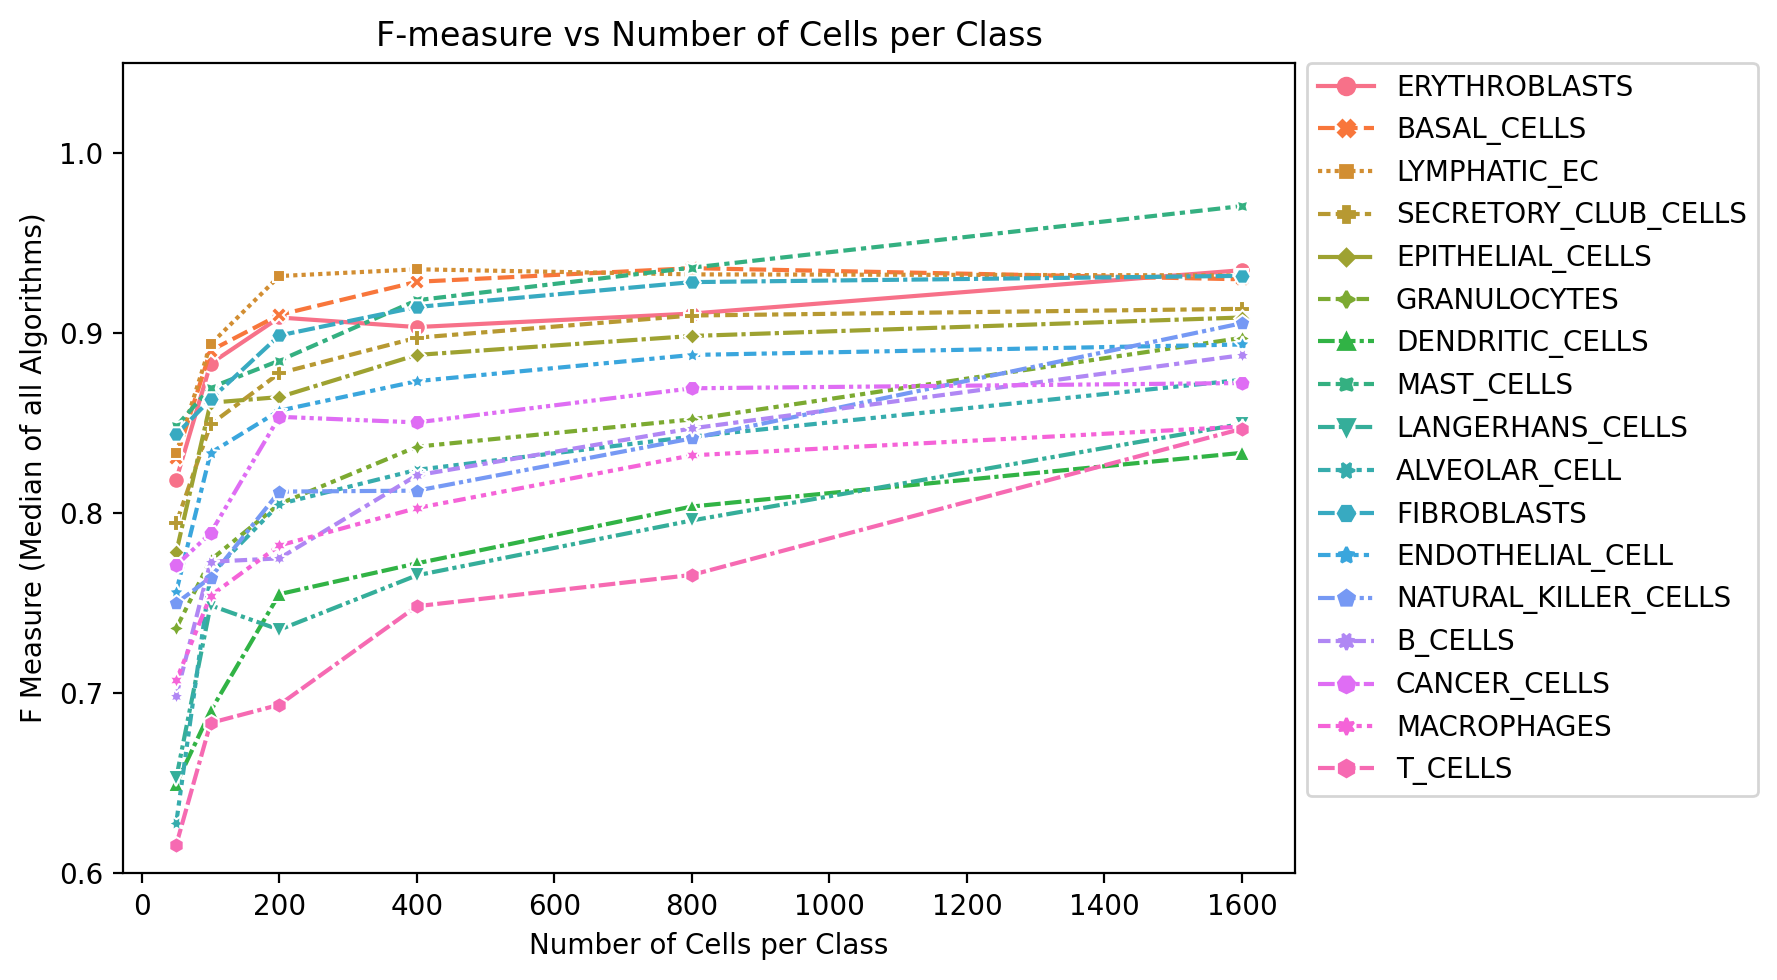

In [6]:
cell_types = list(set(all_subsamples['class']))
fig, lax = plt.subplots(1,1,dpi=200)

    
#display(tempdf)
lnplt = sns.lineplot(y='f1_score',
                     x='support',
                     hue='class',
                     data=all_subsamples, 
                     style="class",
                     markers=True,
                     ci=None,
                     ax=lax
                    )
lnplt.set_ylim(0.6,1.05)
lnplt.set_ylabel('F Measure (Median of all Algorithms)')
lnplt.set_xlabel('Number of Cells per Class')
lnplt.set_title("F-measure vs Number of Cells per Class")
lnplt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

fig.set_figheight(5)
fig.set_figwidth(9)
fig.tight_layout()
plt.savefig(f'./{plotdir}/numcells_vs_f1_lineplot.png', bbox_inches='tight')
plt.show()